In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import math
import time
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial import distance

from sklearn.metrics import silhouette_score


In [2]:
### This notebook contains all the code used for building models for the project.

### In the linear regression model we will see how well the data fits 
### for our purpose of predicting the average annual value (AAV) or "cap hit" of an NHL players contract based on their 
### performance the previous season.

### Each player is then given a salary category based on their cap hit. Then k-means clustering is used to find out 
### where and how these players group together based on the numerical data. The cluster's are explored and analyzed to provide
### sufficient knowledge of finding under and overvalued players and teams that have the best advantage of having 
### high performing players on cheap contracts.

In [3]:
data = pd.read_csv("CS360_nhl_player_stats_with_salary.csv")

In [4]:
data.head()

,playerId,season,name,team,position,games_played,icetime,shifts,gameScore,onIce_xGoalsPercentage,...,OnIce_A_xGoals_with_earned_rebounds_scoreFlurryAdjusted,OffIce_F_xGoals,OffIce_A_xGoals,OffIce_F_shotAttempts,OffIce_A_shotAttempts,draft_round,draft_number,draft_year,salary,cap_hit
0,8480950,2021,Ilya Lyubushkin,TOR,D,77,80654,1788,11.65,0.42,...,65.22,167.08,159.70,3052,2994,undrafted,undrafted,undrafted,2750000.0,2750000.0
1,8476952,2021,Dominic Toninato,WPG,C,77,38801,962,7.34,0.36,...,35.22,235.39,223.36,4033,3827,5,126,2012,750000.0,750000.0
2,8481186,2021,Logan O'Connor,COL,R,81,67415,1539,29.36,0.43,...,53.65,228.73,181.34,4223,3403,undrafted,undrafted,undrafted,900000.0,1050000.0
3,8477447,2021,Shea Theodore,VGK,D,78,108267,2050,65.37,0.55,...,83.22,144.52,152.32,2805,2897,1,26,2013,5200000.0,5200000.0
4,8475167,2021,Victor Hedman,TBL,D,82,123372,2214,90.42,0.57,...,103.19,130.83,145.92,2398,2727,1,2,2009,5000000.0,7875000.0


In [6]:
## exploring the data

data.shape # 584 rows & 152 columns

## seems to have multiple data types

## finding missing values
data.isna().sum() # we see that there is one player on the dataset who doesn't have a listed salary and cap hit
## deleting the record(s) with missing values
data.dropna(subset = ["salary", "cap_hit"], inplace=True)

## finding duplicate columns (columns that share identical information)
duplicate_col_names = set()
for i in range(data.shape[1]):
    col = data.iloc[:, i]
    for j in range(i + 1, data.shape[1]):
        other_col = data.iloc[:, j]
        if col.equals(other_col):
            duplicate_col_names.add(data.columns.values[j])
print(list(duplicate_col_names)) # should be ['faceoffsWon', 'penalityMinutes', 'I_F_shifts']

['faceoffsWon', 'penalityMinutes', 'I_F_shifts']


In [7]:
## drop columns that are identical
data.drop(columns=duplicate_col_names, inplace=True)

In [8]:
data.shape # 583, 149

(583, 149)

In [9]:
## reseting index
data.reset_index(drop=True, inplace=True)

In [10]:
data

,playerId,season,name,team,position,games_played,icetime,shifts,gameScore,onIce_xGoalsPercentage,...,OnIce_A_xGoals_with_earned_rebounds_scoreFlurryAdjusted,OffIce_F_xGoals,OffIce_A_xGoals,OffIce_F_shotAttempts,OffIce_A_shotAttempts,draft_round,draft_number,draft_year,salary,cap_hit
0,8480950,2021,Ilya Lyubushkin,TOR,D,77,80654,1788,11.65,0.42,...,65.22,167.08,159.70,3052,2994,undrafted,undrafted,undrafted,2750000.0,2750000.0
1,8476952,2021,Dominic Toninato,WPG,C,77,38801,962,7.34,0.36,...,35.22,235.39,223.36,4033,3827,5,126,2012,750000.0,750000.0
2,8481186,2021,Logan O'Connor,COL,R,81,67415,1539,29.36,0.43,...,53.65,228.73,181.34,4223,3403,undrafted,undrafted,undrafted,900000.0,1050000.0
3,8477447,2021,Shea Theodore,VGK,D,78,108267,2050,65.37,0.55,...,83.22,144.52,152.32,2805,2897,1,26,2013,5200000.0,5200000.0
4,8475167,2021,Victor Hedman,TBL,D,82,123372,2214,90.42,0.57,...,103.19,130.83,145.92,2398,2727,1,2,2009,5000000.0,7875000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,8474089,2021,Brad Malone,EDM,C,8,3974,108,1.37,0.32,...,4.61,25.14,21.32,437,408,4,105,2007,750000.0,762500.0
579,8482149,2021,Cole Perfetti,WPG,C,18,15280,313,8.64,0.55,...,9.76,44.77,48.68,774,795,1,10,2020,832500.0,894167.0
580,8477070,2021,Liam O'Brien,ARI,C,39,22177,548,-1.05,0.36,...,16.22,81.19,109.56,1568,2075,undrafted,undrafted,undrafted,750000.0,775000.0
581,8479996,2021,Cody Glass,NSH,C,8,5476,132,1.91,0.69,...,2.67,18.41,19.47,365,318,1,6,2017,874125.0,874125.0


In [11]:
data.dtypes.value_counts() # seems to have multiple (3) data types

int64      79
float64    64
object      6
dtype: int64

In [12]:
data.select_dtypes(include=[int, float]).kurt().nlargest(5) ## kurtosis of normal distribution = 3

I_F_reboundGoals       3.914210
I_F_highDangerGoals    3.768563
I_F_lowDangerGoals     3.662046
I_F_faceOffsWon        3.487695
I_F_dZoneGiveaways     2.784652
dtype: float64

In [13]:
data.select_dtypes(include=[int, float]).skew().nsmallest(5)

games_played            -1.282090
timeOnBench             -1.231686
OffIce_A_shotAttempts   -1.184730
OffIce_A_xGoals         -1.059669
OffIce_F_shotAttempts   -0.896037
dtype: float64

In [14]:
data.select_dtypes(include=[int, float]).skew().nlargest(5)

I_F_faceOffsWon        2.096002
faceoffsLost           1.815738
I_F_reboundGoals       1.800763
I_F_highDangerGoals    1.797126
I_F_lowDangerGoals     1.604082
dtype: float64

In [16]:
#print(data.describe())

C:\Users\rsmid\AppData\Local\Temp/ipykernel_7556/26604794.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 2, figsize=(10,4))


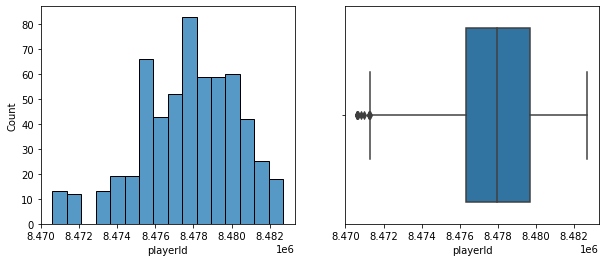

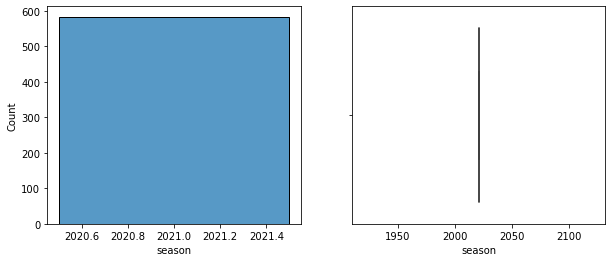

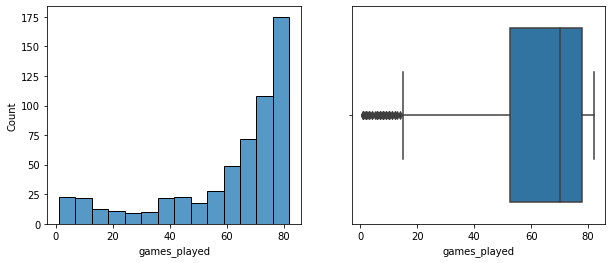

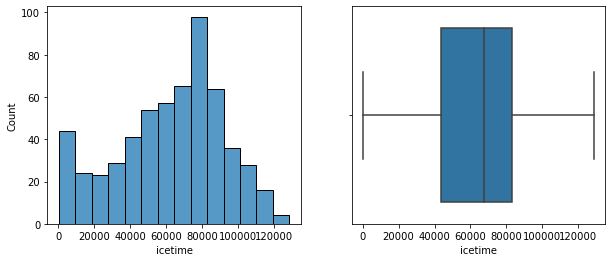

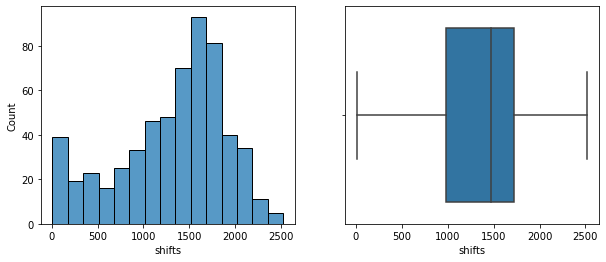

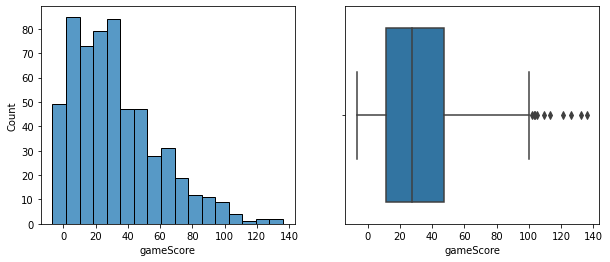

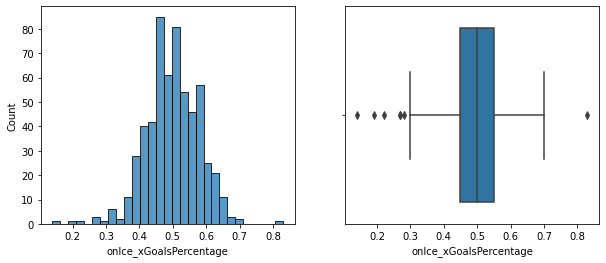

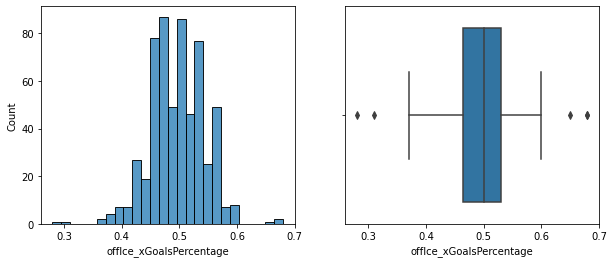

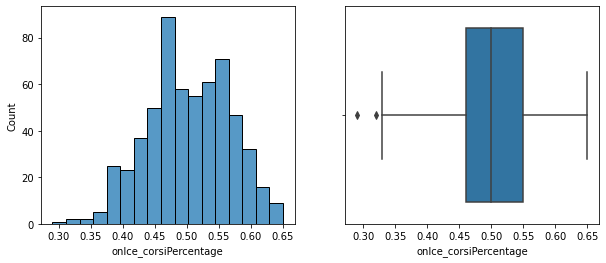

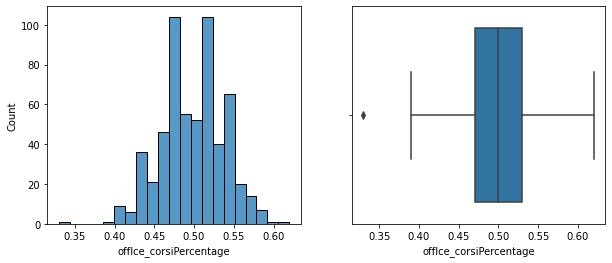

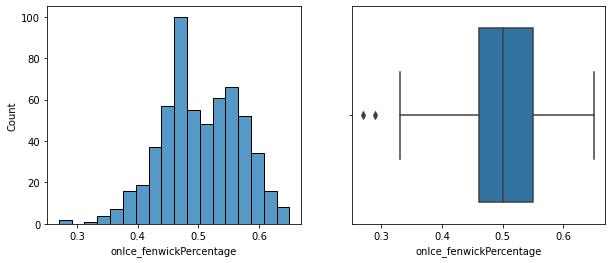

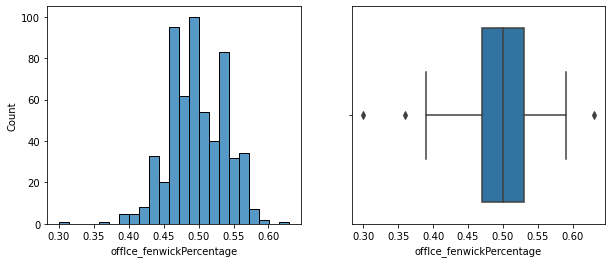

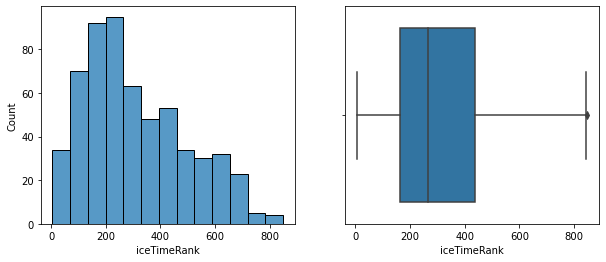

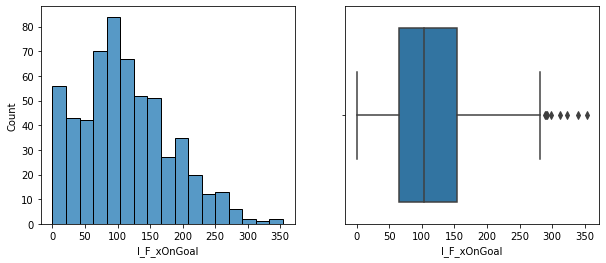

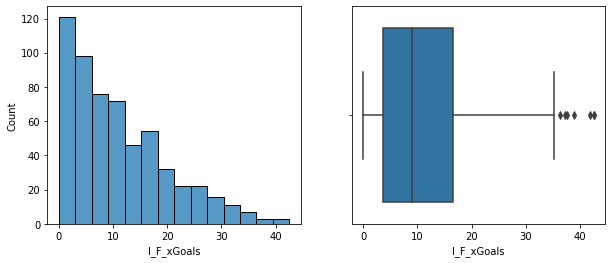

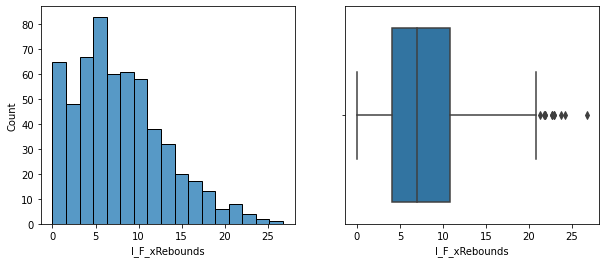

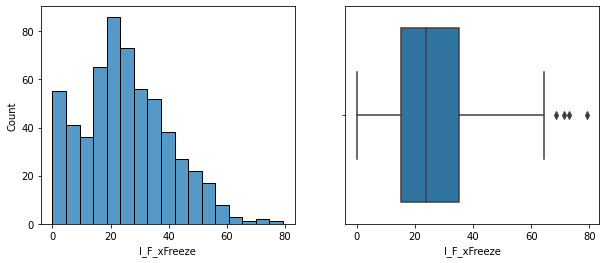

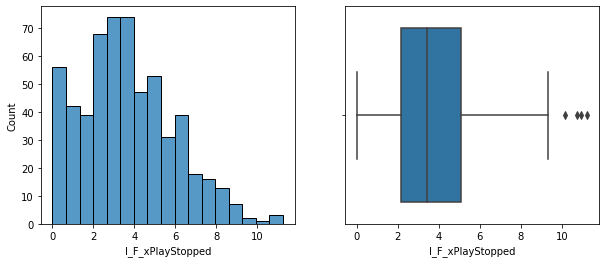

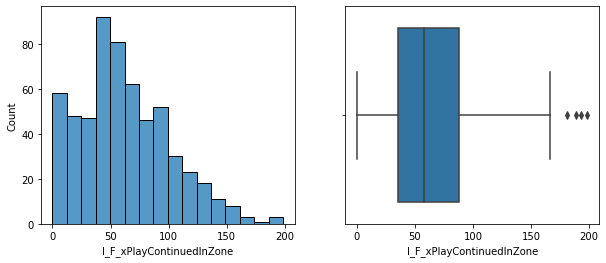

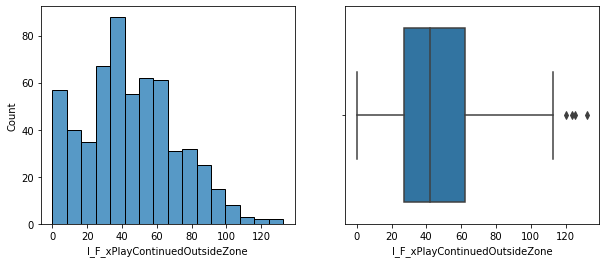

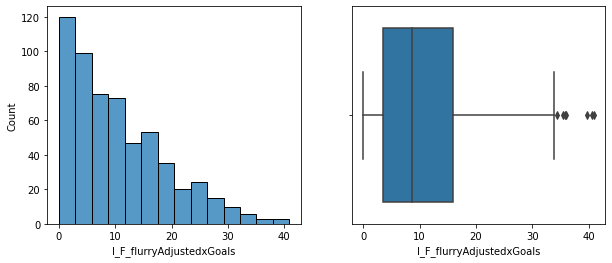

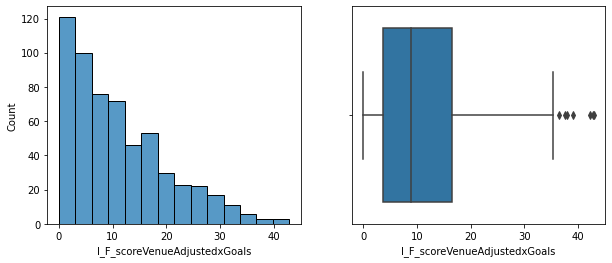

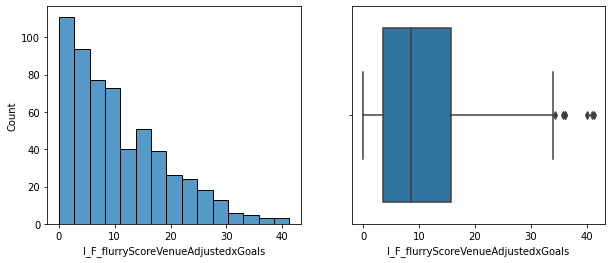

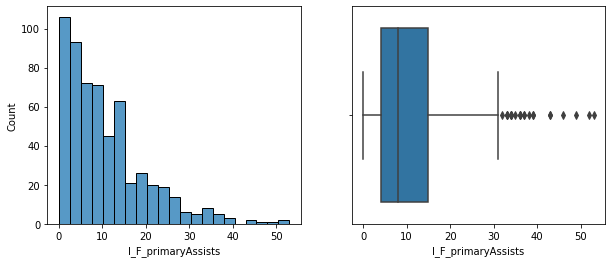

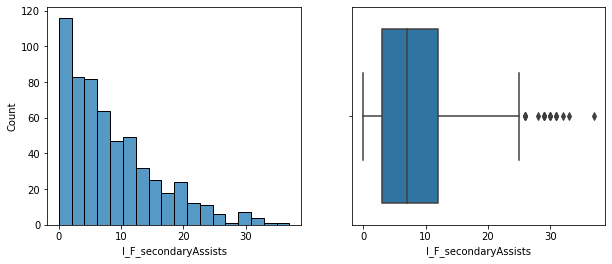

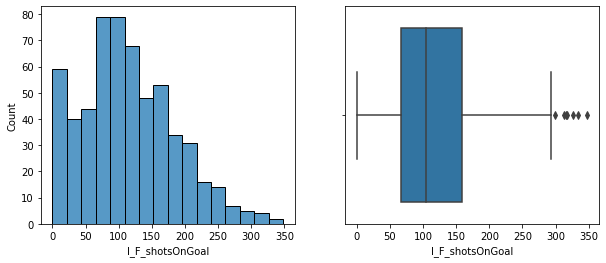

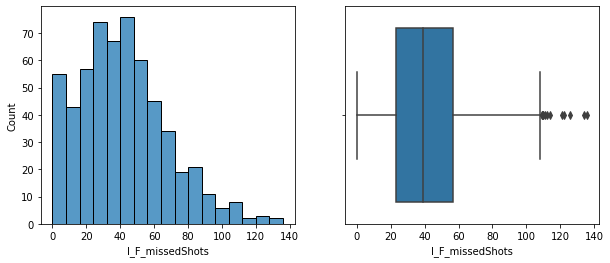

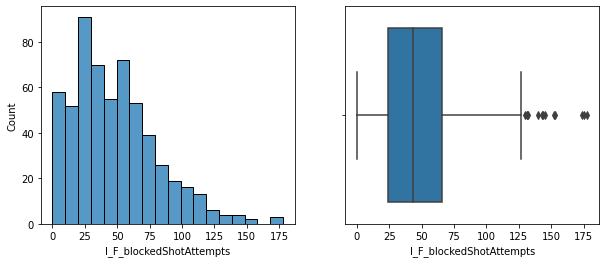

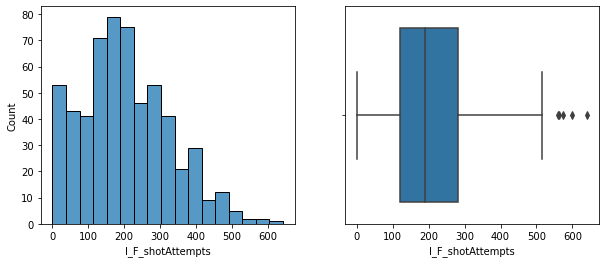

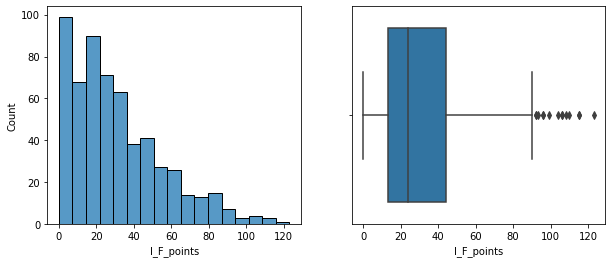

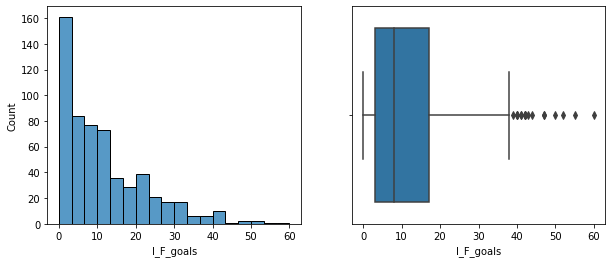

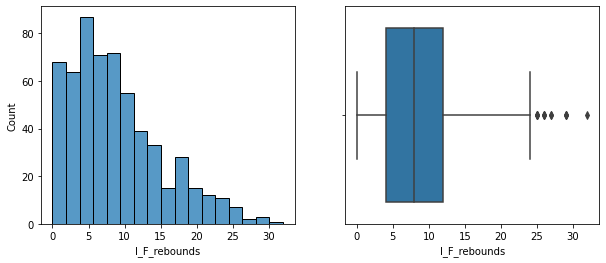

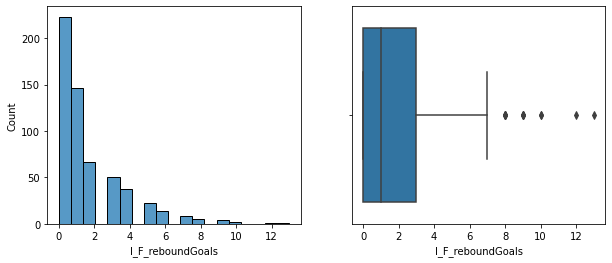

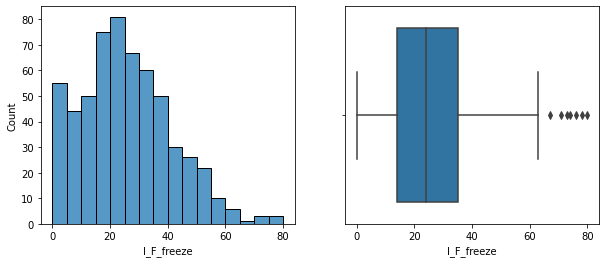

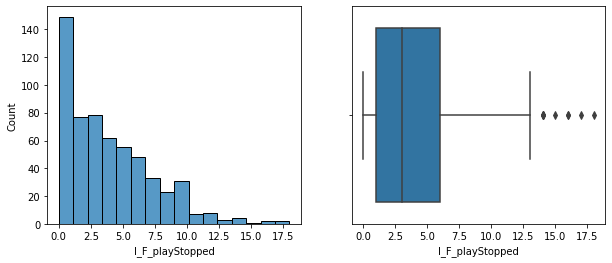

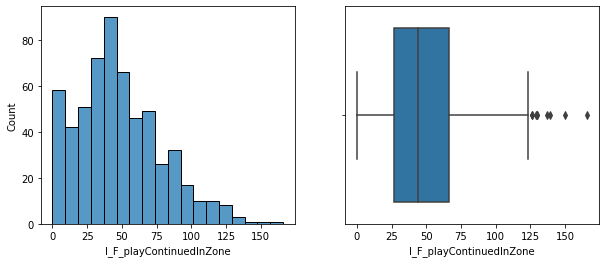

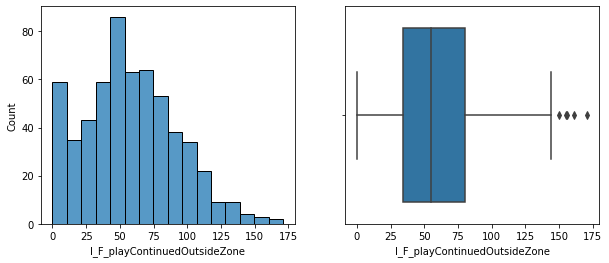

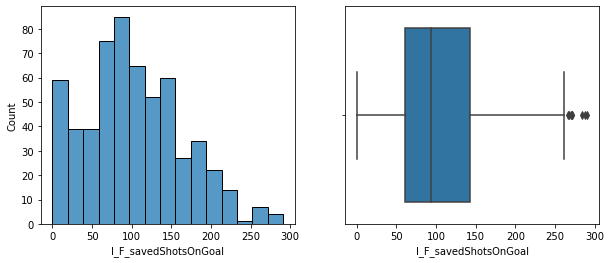

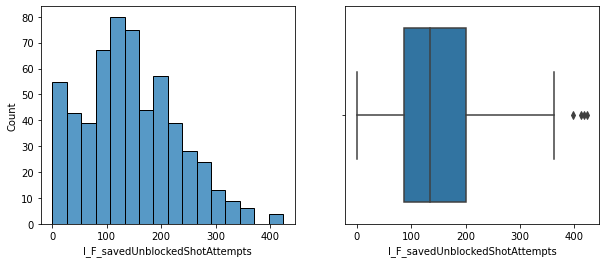

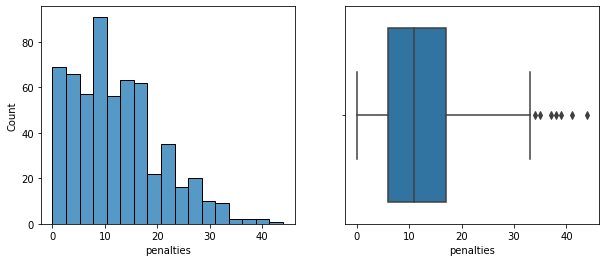

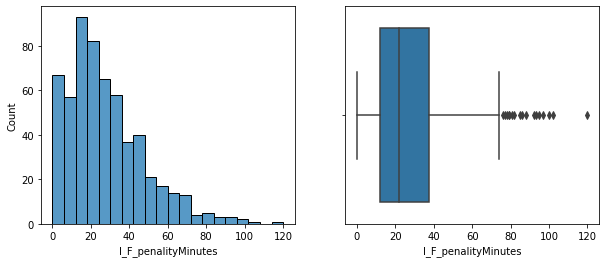

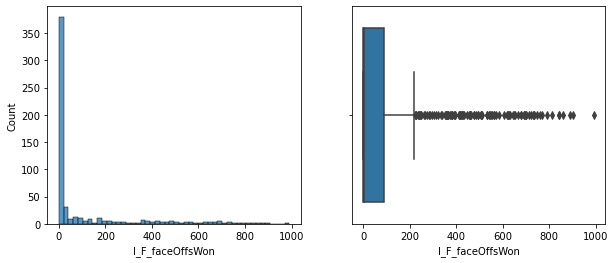

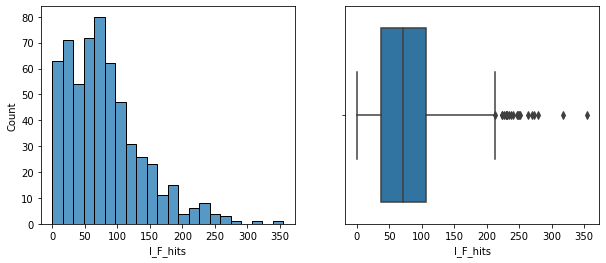

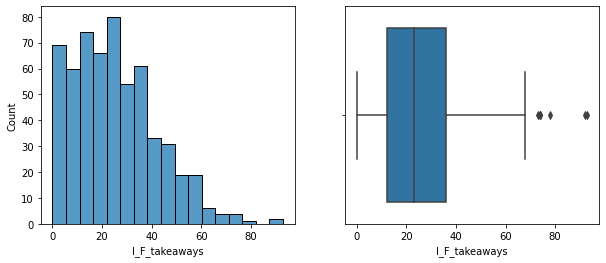

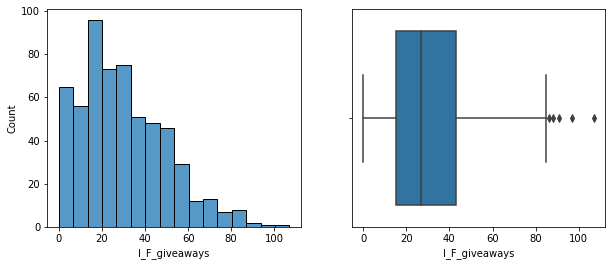

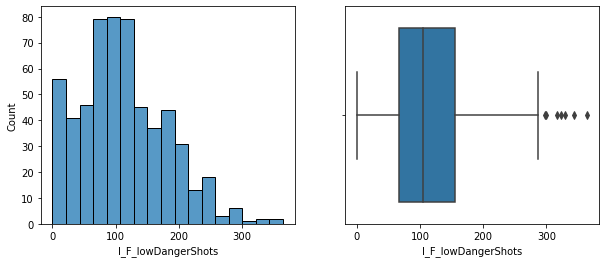

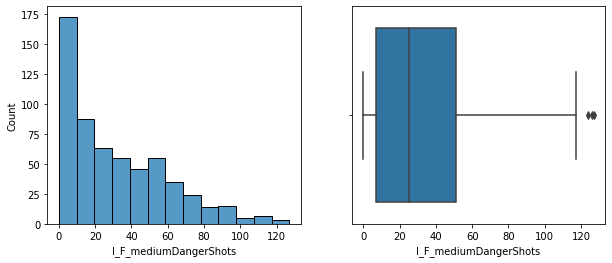

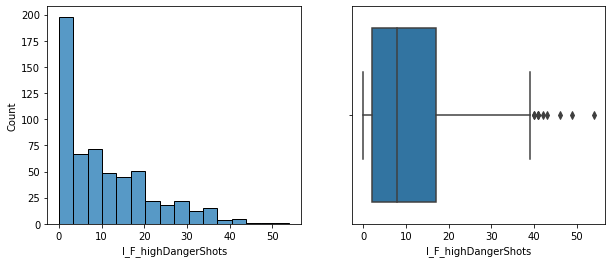

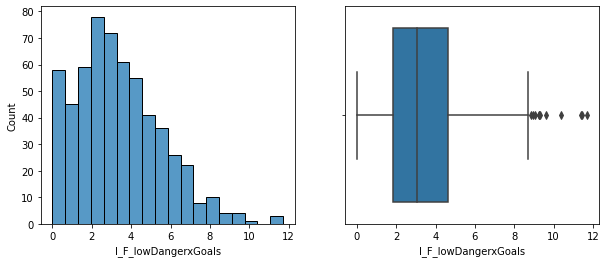

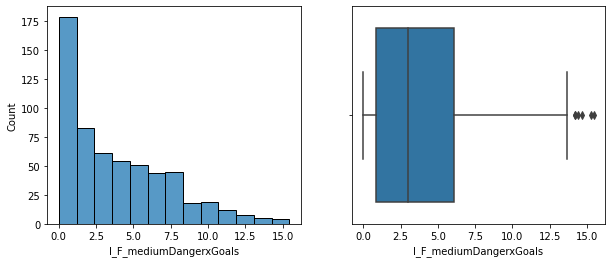

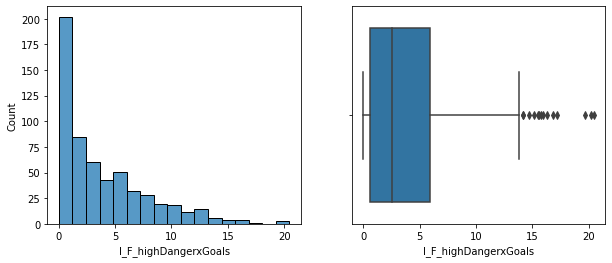

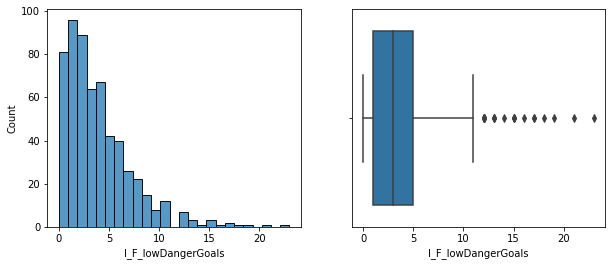

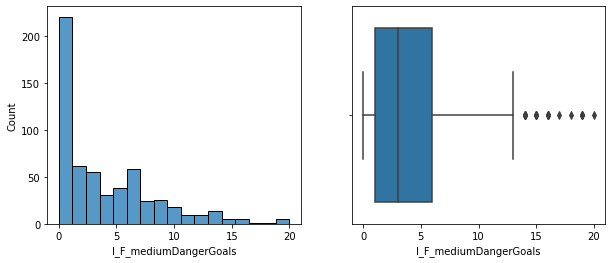

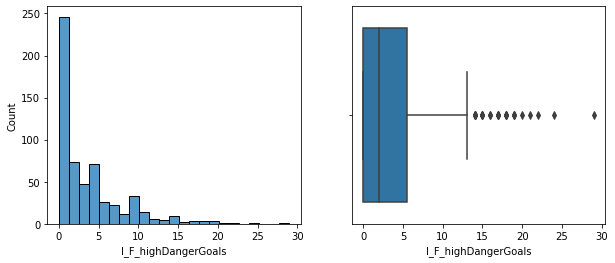

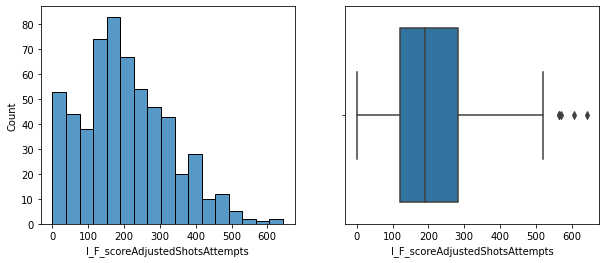

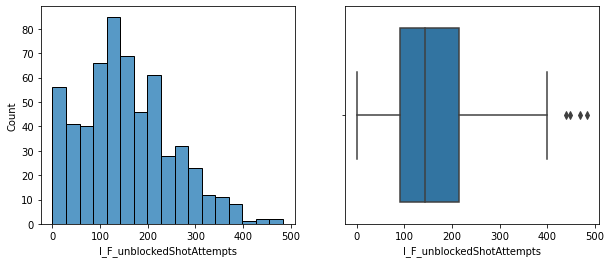

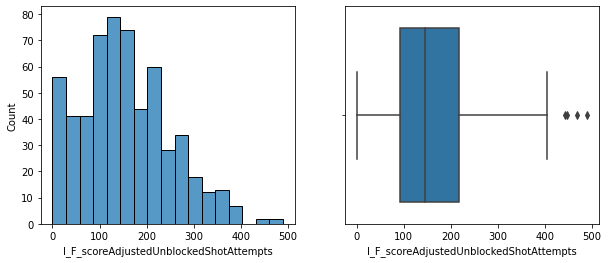

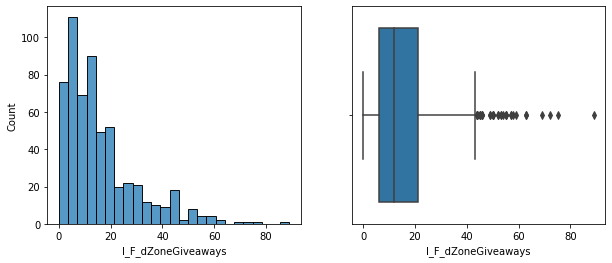

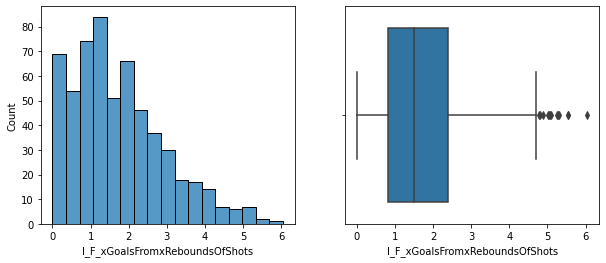

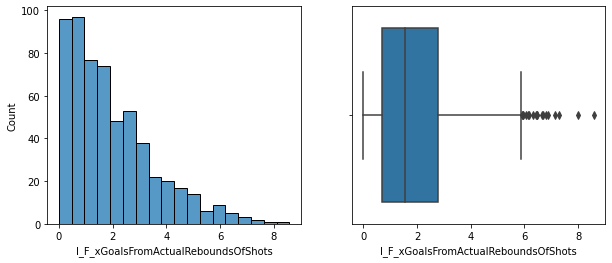

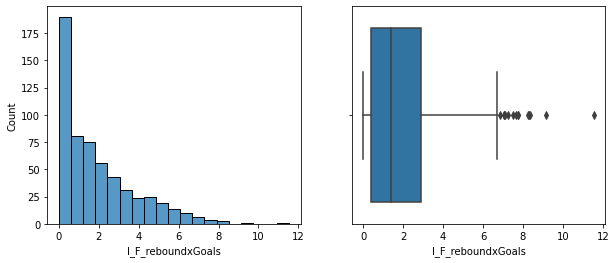

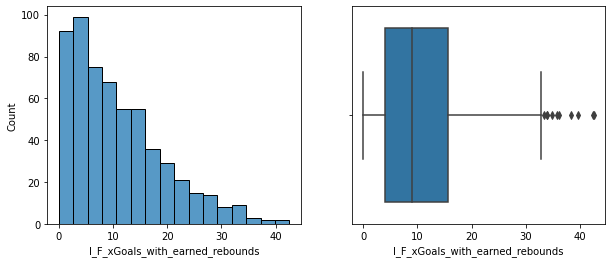

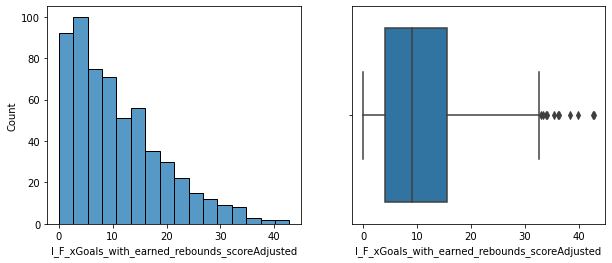

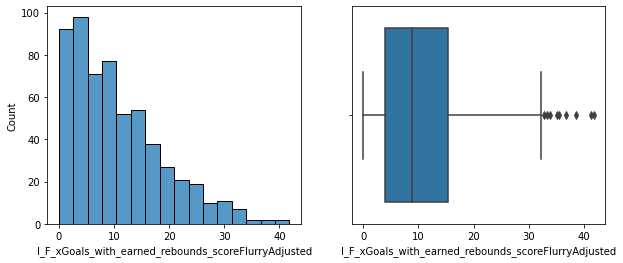

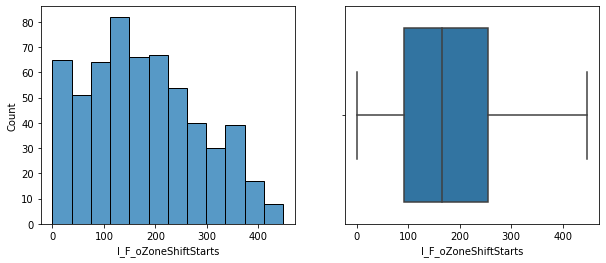

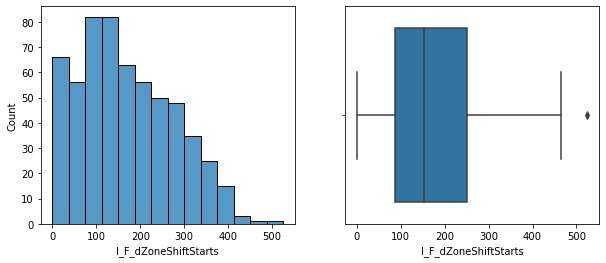

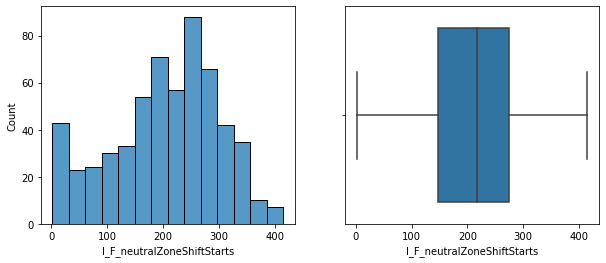

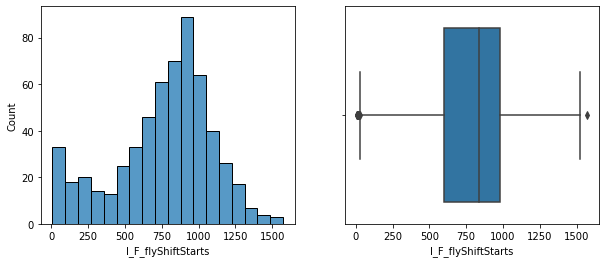

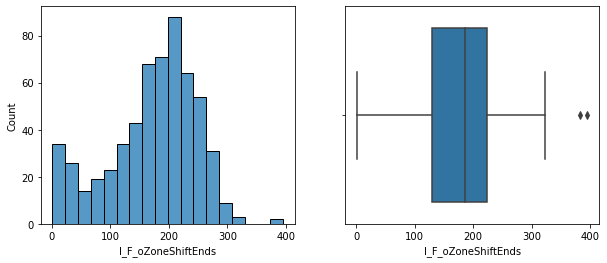

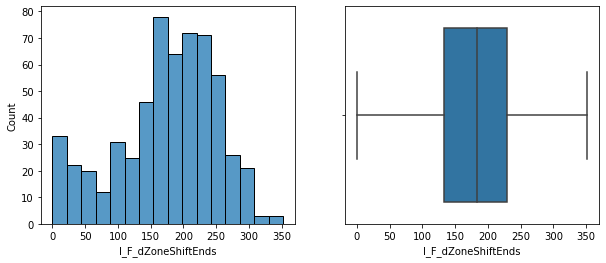

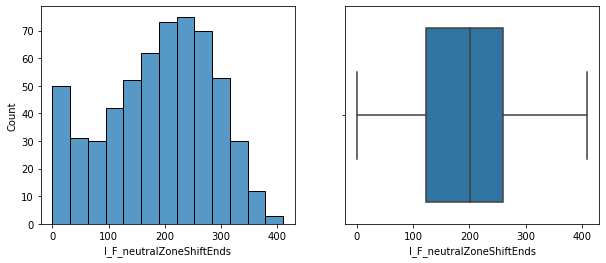

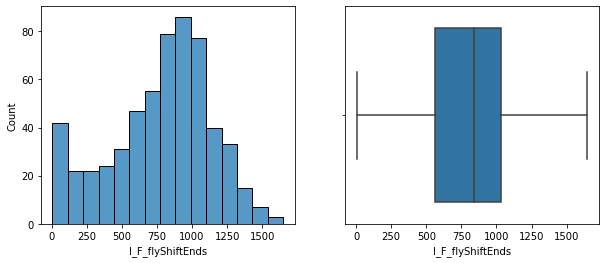

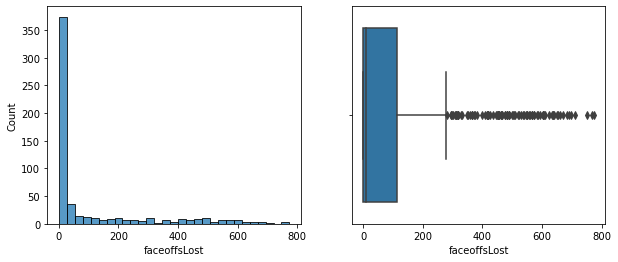

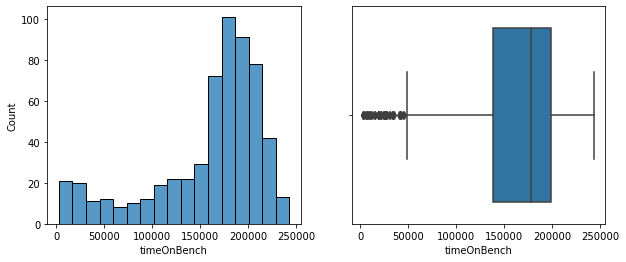

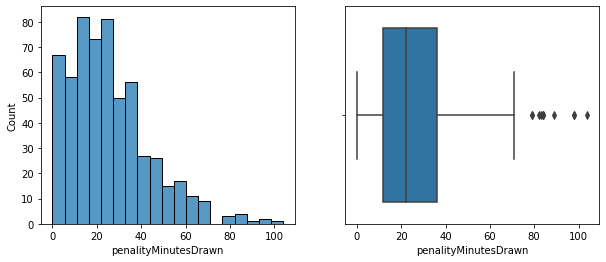

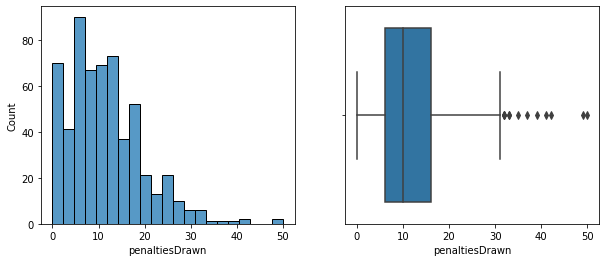

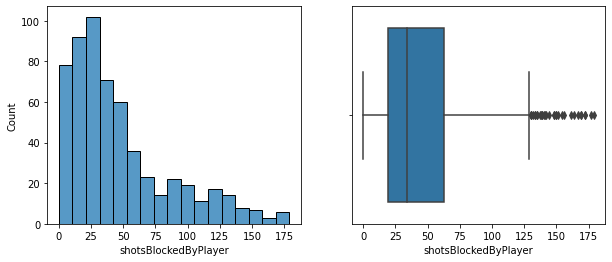

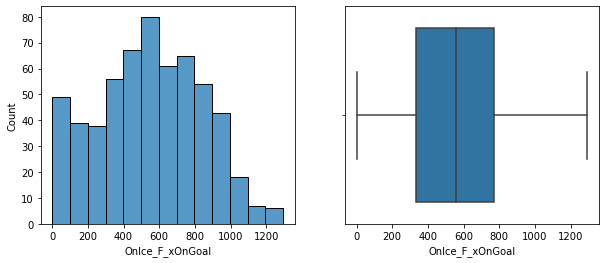

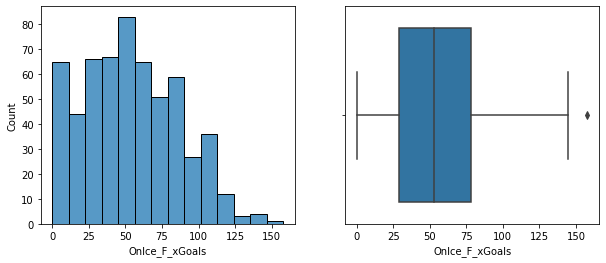

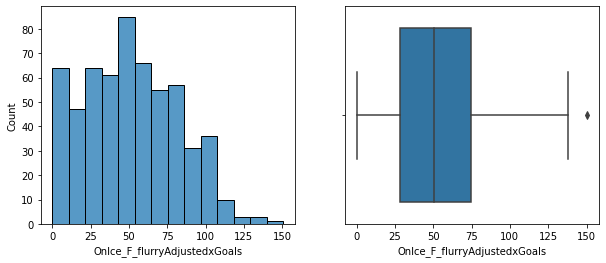

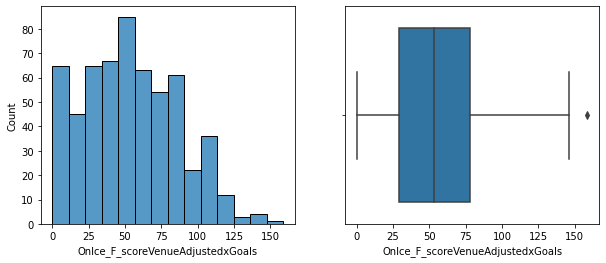

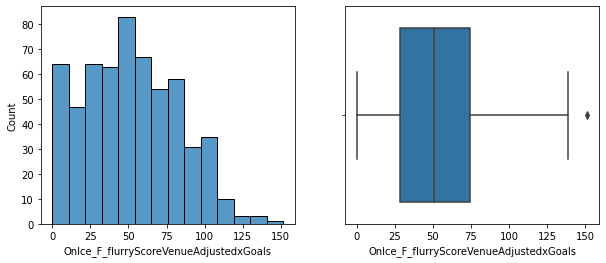

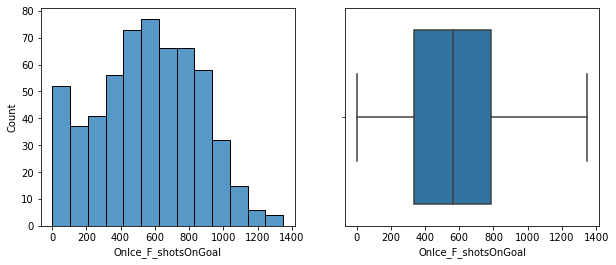

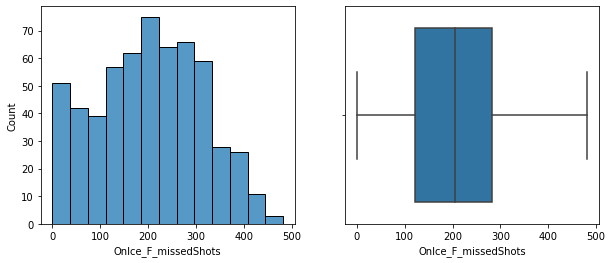

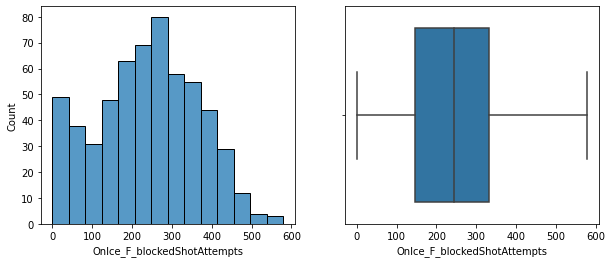

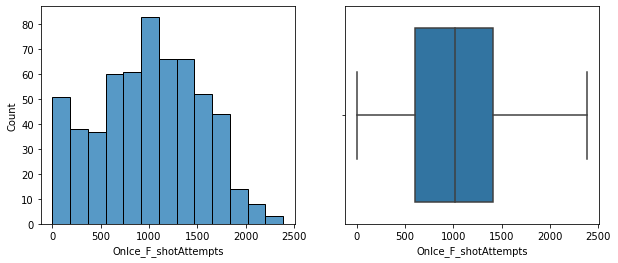

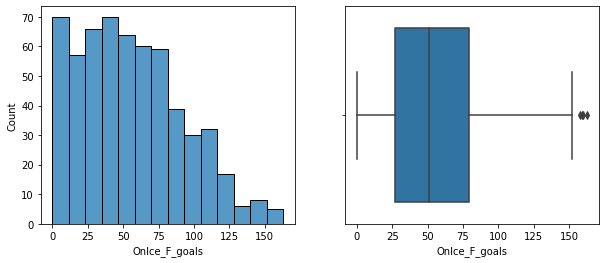

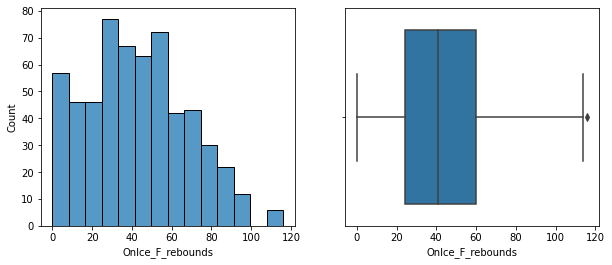

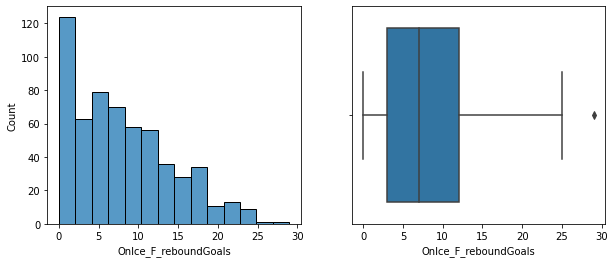

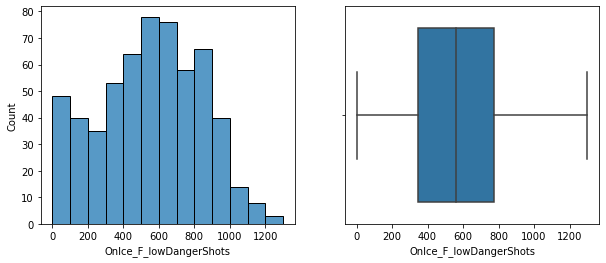

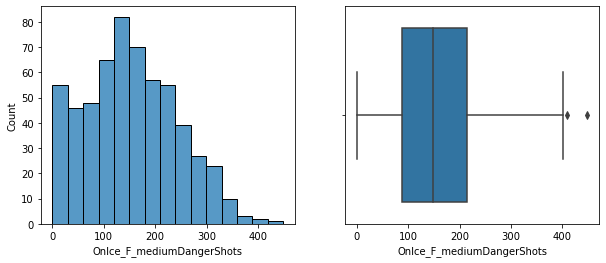

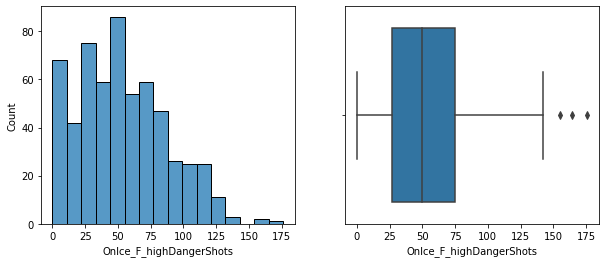

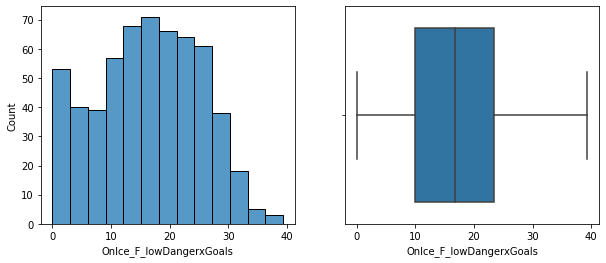

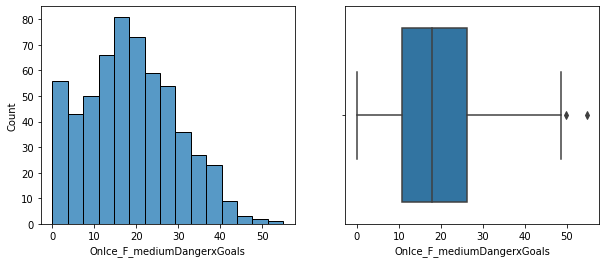

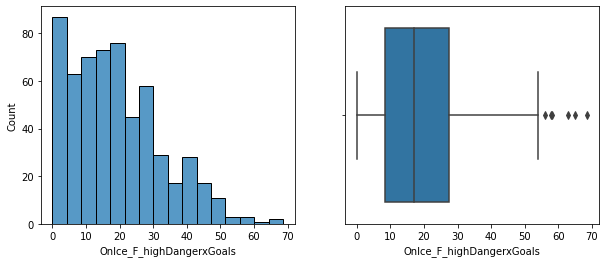

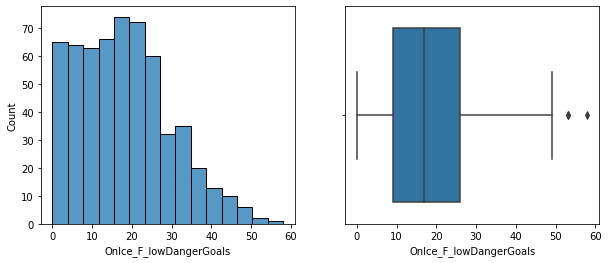

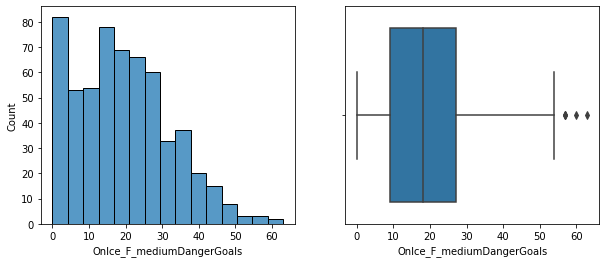

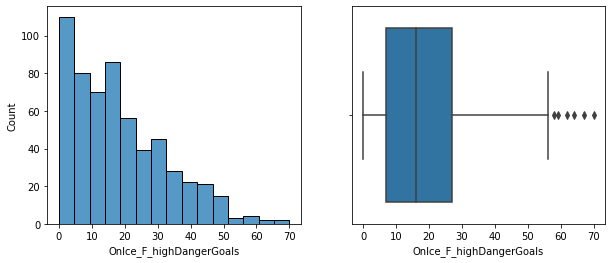

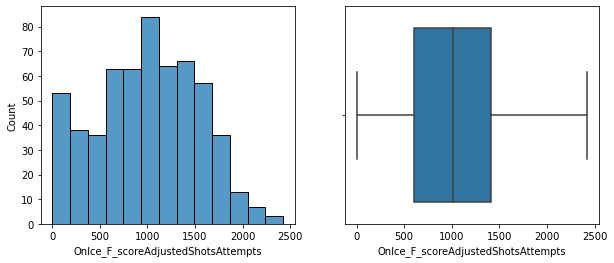

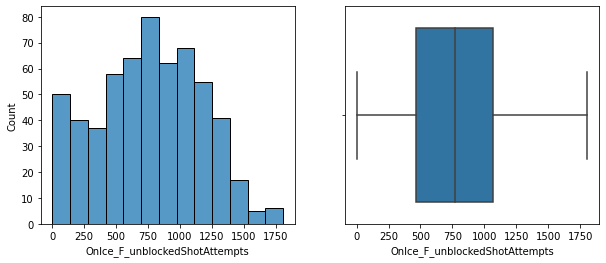

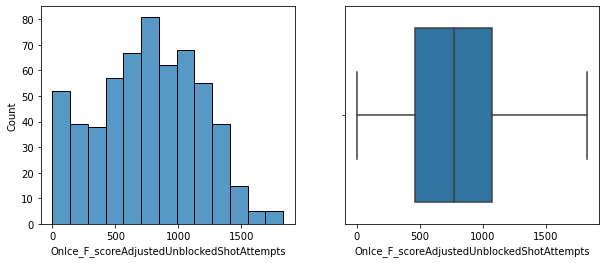

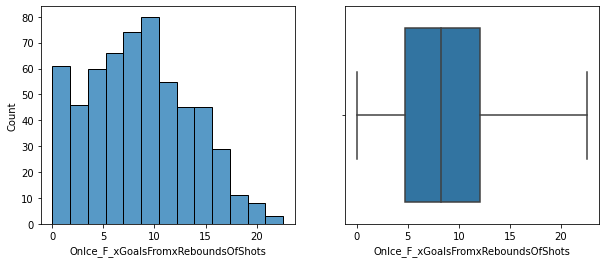

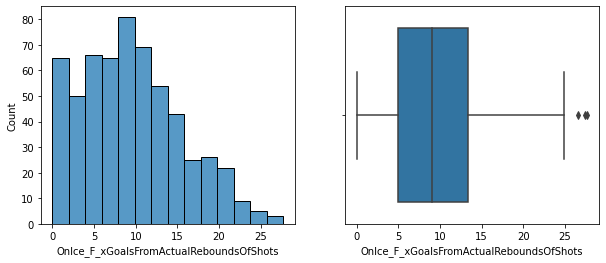

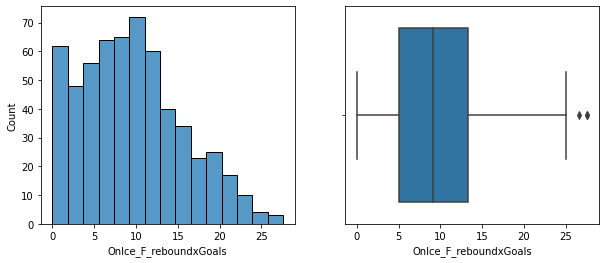

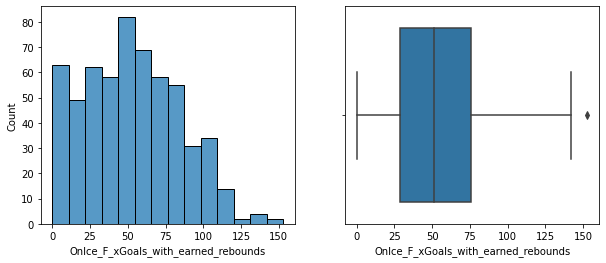

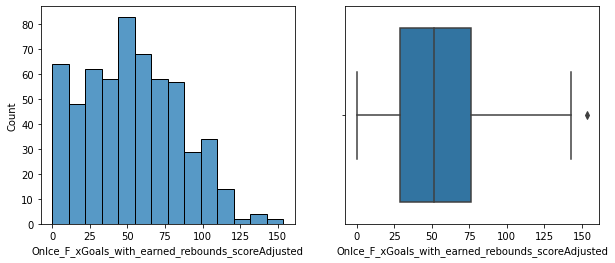

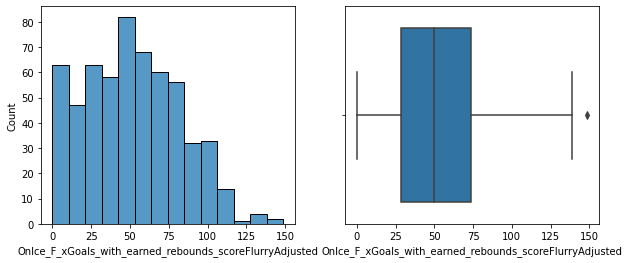

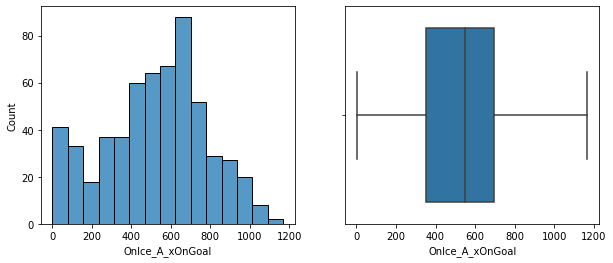

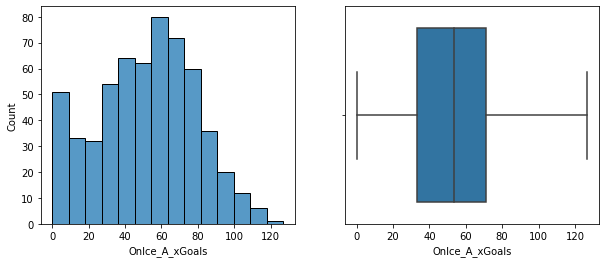

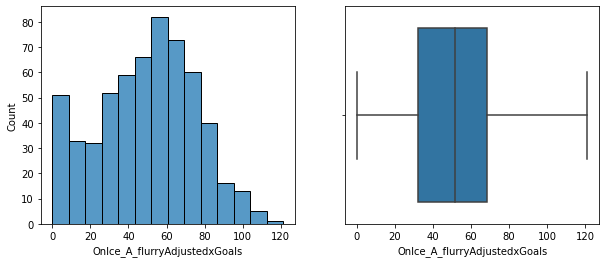

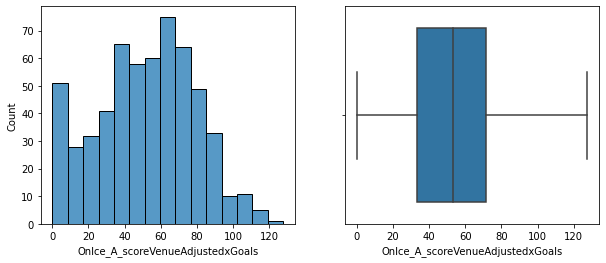

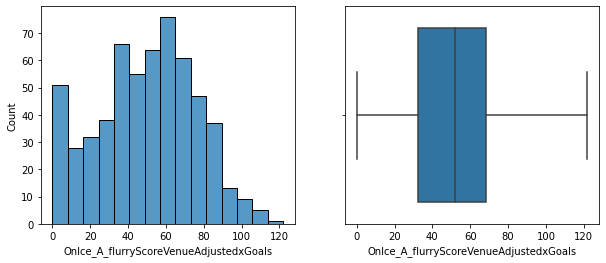

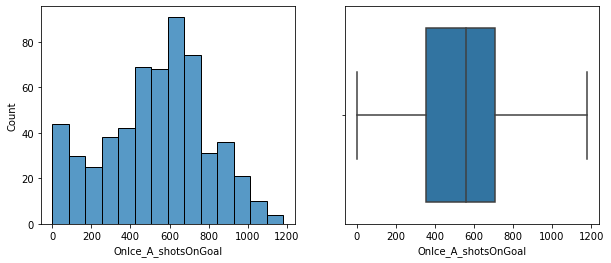

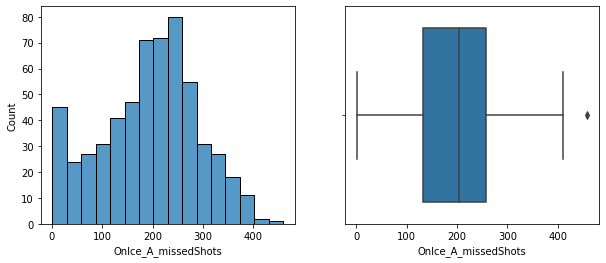

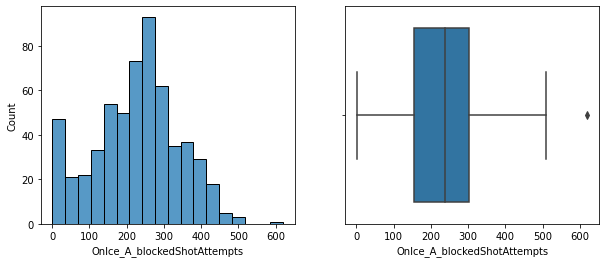

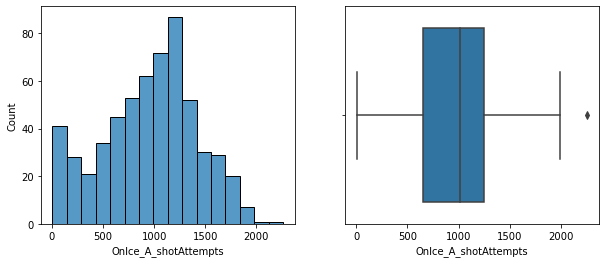

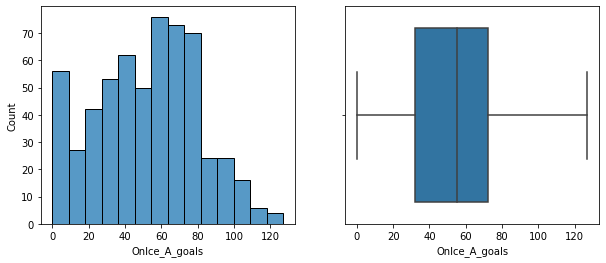

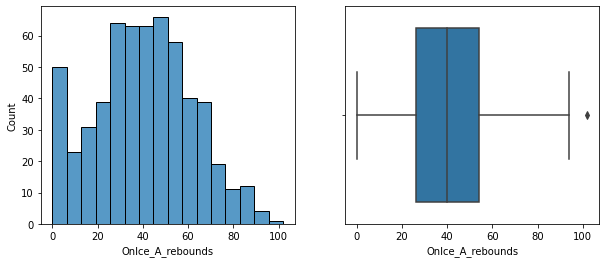

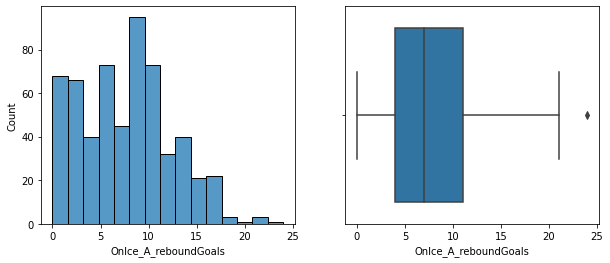

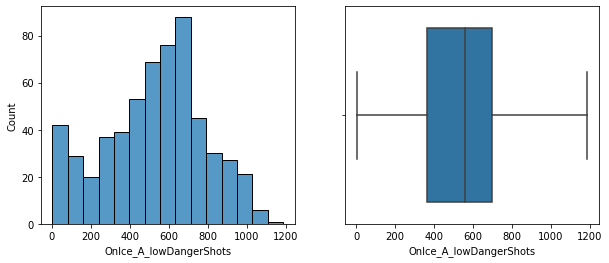

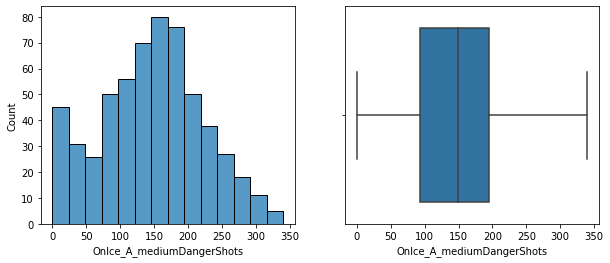

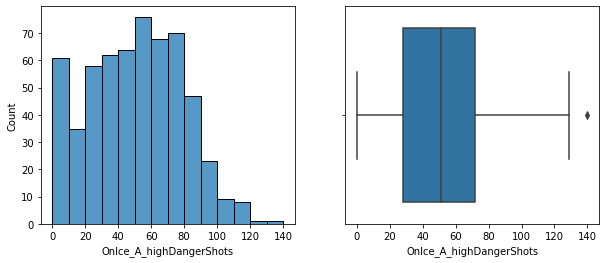

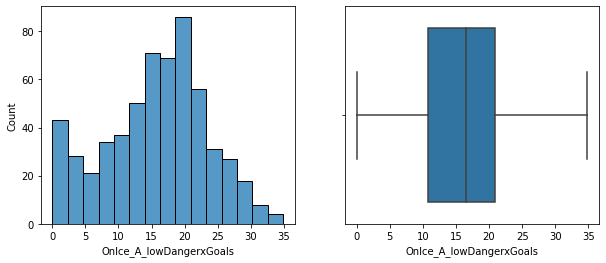

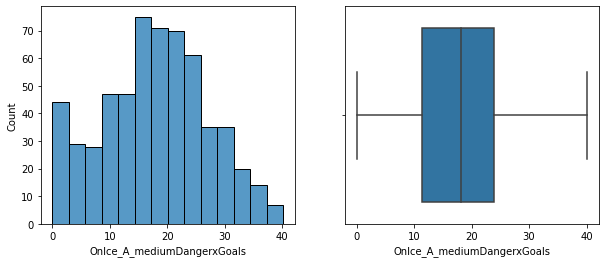

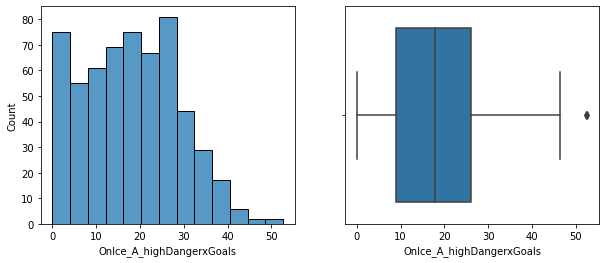

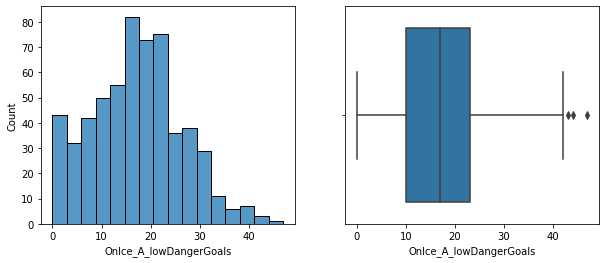

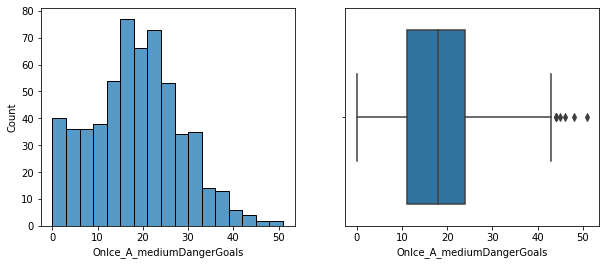

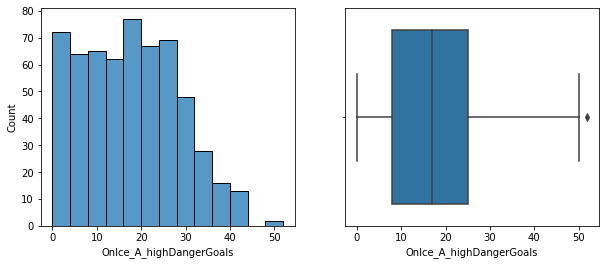

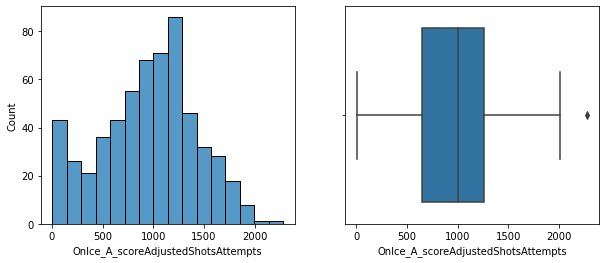

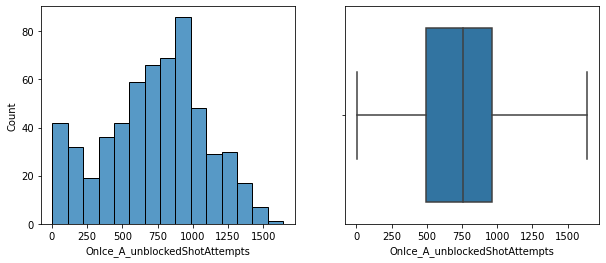

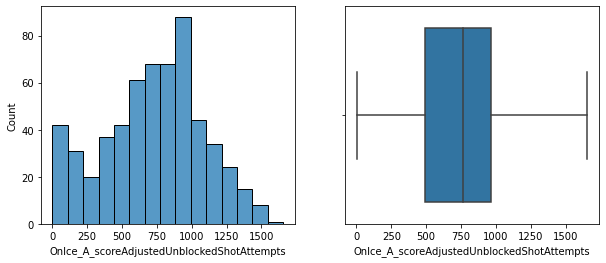

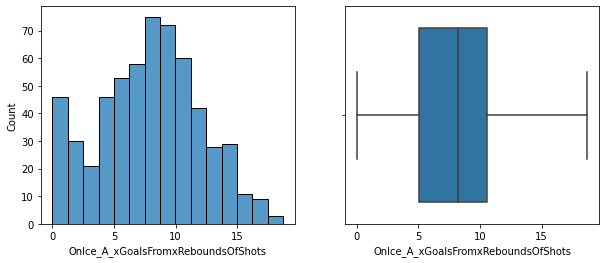

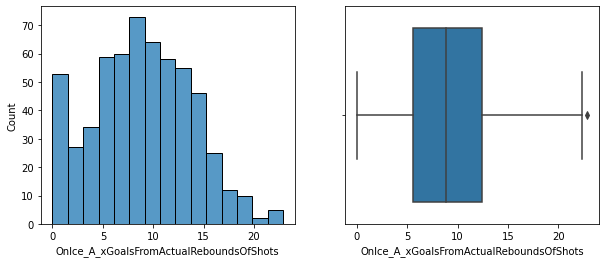

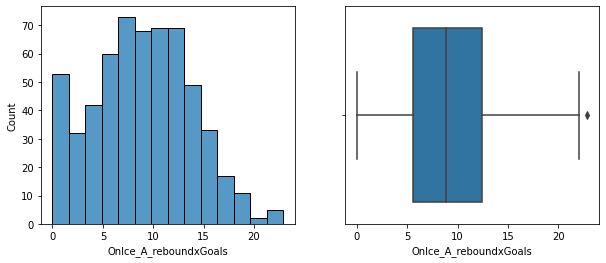

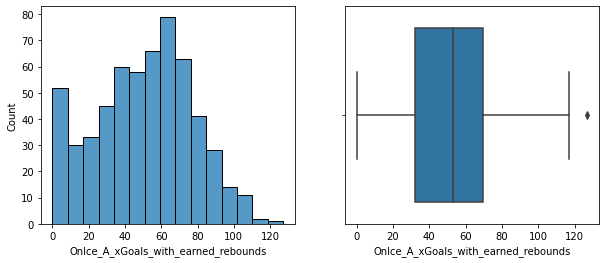

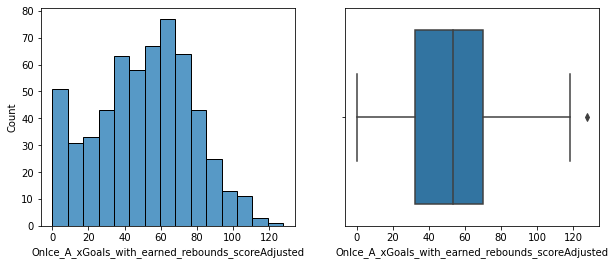

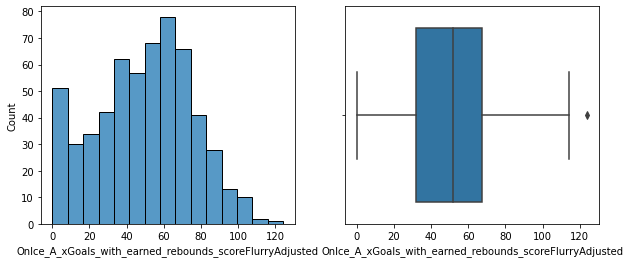

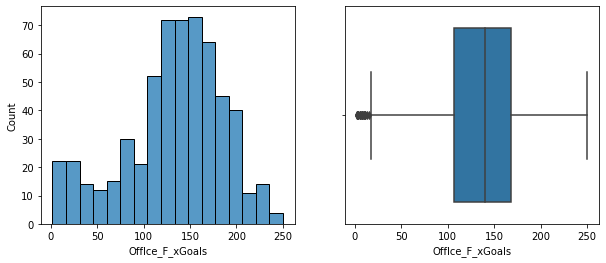

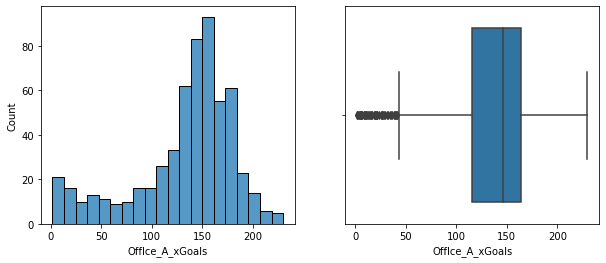

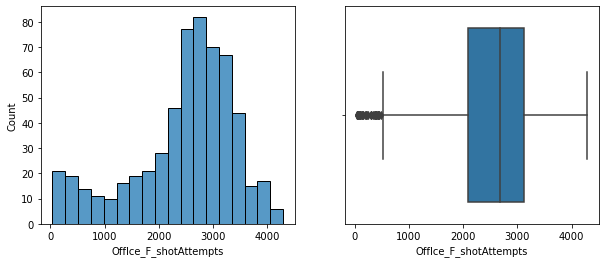

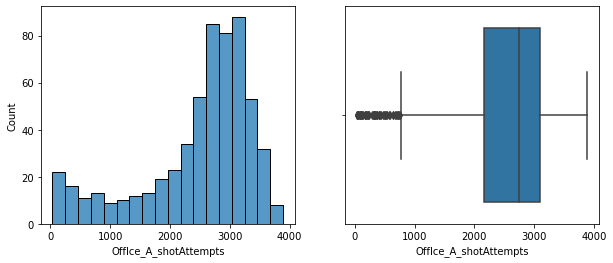

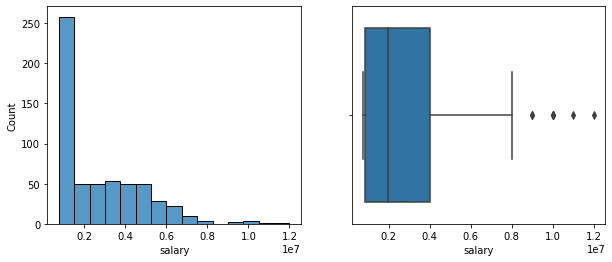

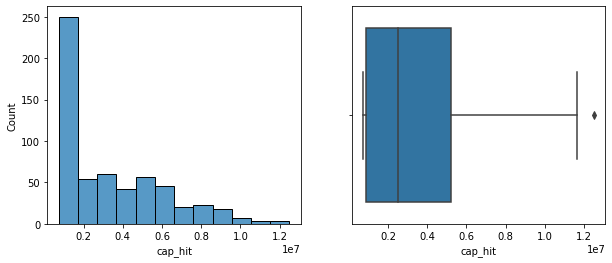

In [17]:
## visualize each numerical attribute

num_attributes = data.select_dtypes(include=[int,float]).columns
for col in num_attributes:
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    sns.histplot(data=data, x=col, ax=ax[0])
    sns.boxplot(data=data, x=col, ax=ax[1]);

(array([333., 116.,  82.,  44.,   8.]),
 array([  733333. ,  3086666.4,  5439999.8,  7793333.2, 10146666.6,
        12500000. ]),
 <BarContainer object of 5 artists>)

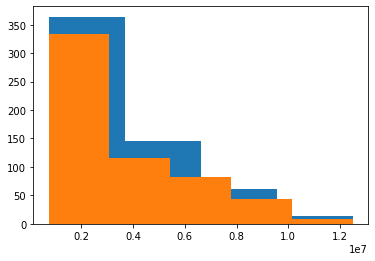

In [18]:
## creating another histogram for cap hit (aav salary) ranges

plt.hist(data['cap_hit'], bins=4)

plt.hist(data['cap_hit'], bins=5)
# using 5 bins provided best looking results describing the proportions of contract values (many small contracts, few big ones)

In [19]:
## let's see how many players there are for each position

data['position'].value_counts() # num of centers and defenders close to equal, num of wingers (L + R) approx 20 less

C    204
D    201
L     98
R     80
Name: position, dtype: int64

array([[<AxesSubplot:title={'center':'C'}>,
        <AxesSubplot:title={'center':'D'}>],
       [<AxesSubplot:title={'center':'L'}>,
        <AxesSubplot:title={'center':'R'}>]], dtype=object)

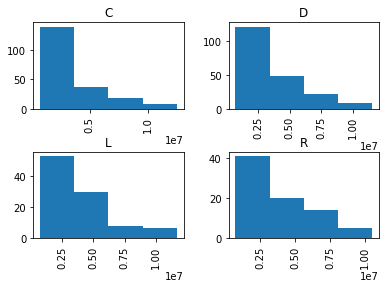

In [20]:
## visualizing the cap_hit proportions for each position

data.hist(column='cap_hit', bins=4, by='position')

array([[<AxesSubplot:title={'center':'C'}>,
        <AxesSubplot:title={'center':'D'}>],
       [<AxesSubplot:title={'center':'L'}>,
        <AxesSubplot:title={'center':'R'}>]], dtype=object)

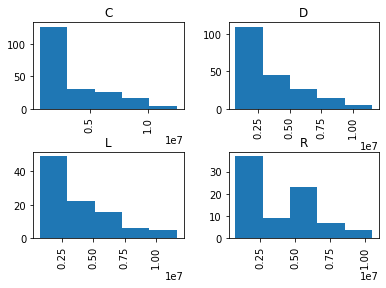

In [21]:
data.hist(column='cap_hit', bins=5, by='position')

In [22]:
## the lowest bin has a very high proportion of records and range from min value contracts to aav of 3 million
## consider adjusting the bins

(array([286., 150.,  89.,  47.,  11.]),
 array([       0,  2500000,  5200000,  7500000, 10000000, 12500000]),
 <BarContainer object of 5 artists>)

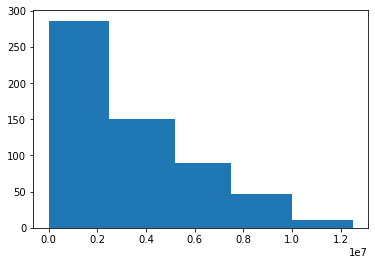

In [23]:
## using the values of the first histogram, let's ball park the bins to create 5 salary categories 
## (use them later as labels for k-means clustering)
plt.hist(data['cap_hit'], bins=[0,2500000,5200000,7500000,10000000,12500000])

(array([230., 166., 118.,  69.]),
 array([       0,  1500000,  4500000,  7000000, 12500000]),
 <BarContainer object of 4 artists>)

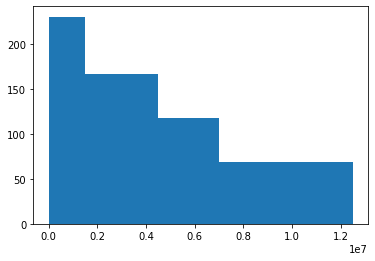

In [24]:
## adjusted 4 new bins 
## now there are more records on the top category (high earners)
plt.hist(data['cap_hit'], bins=[0,1500000,4500000,7000000,12500000])

In [25]:
## creating labels for 4 classes (pseudo)
contracts_dict = {
    0: "Entry Level",
    1: "Squad Player",
    2: "Star Player",
    3: "Superstar",
}

In [26]:
## setting colors for each salary_cat (used later for visualization)
colors = ['steelblue', 'dodgerblue', 'lightskyblue', 'lightcyan']
color_codes =[]
for clr in colors[::-1]:
    color_codes.append(mcolors.CSS4_COLORS[clr])

In [27]:
slry_cat_list = []
for i in range(len(data)):
    aav = data.iloc[i]['cap_hit']
    if aav < 1500000:
        slry_cat = 0
    elif aav >= 1500000 and aav < 4500000:
        slry_cat = 1
    elif aav >= 4500000 and aav < 7000000:
        slry_cat = 2
    elif aav >= 7000000:
        slry_cat = 3
    slry_cat_list.append(slry_cat)

In [28]:
## adding column 'salary_cat'
data['salary_cat'] = slry_cat_list

In [29]:
## creating dummies for positions and draft rounds, let draft_year be as it is

draft_round_dummies= pd.get_dummies(data['draft_round'])
position_dummies = pd.get_dummies(data['position'])

## rename columns
new_column_lst = ['draft_round_1', 'draft_round_2', 'draft_round_3', 'draft_round_4','draft_round_5', 
                  'draft_round_6', 'draft_round_7', 'undrafted']
draft_round_dummies = draft_round_dummies.set_axis(new_column_lst, axis=1)

## join dummies
dummies = position_dummies.join(draft_round_dummies, how='outer')

In [30]:
## copying the data and dropping columns 'playerId','season','team','name','position','salary', 'cap_hit',
## 'draft_round','draft_number', and 'draft_year'
dataset_wo_dummies = data.copy()
dataset_wo_dummies.drop(columns=['playerId','season','team','name','position','salary', 'cap_hit',
                                            'draft_round','draft_number', 'draft_year'], inplace=True)
#dataset_wo_dummies

In [31]:
## joining dummies with the stats and salary bin data
dataset = dummies.join(dataset_wo_dummies, how='outer') ## dataset is the dataset with dummies

In [32]:
## NEXT: LET'S TRY LINEAR REGRESSION TO SEE WHICH ATTRIBUTES CORRELATE ON TRUE CAP_HIT VALUES
## REDUCE DIMENSIONALITY BY CHOOSING n ATTRIBUTES WITH THE HIGHEST CORRELATIONS (GET RID OF IRRELEVANT ATTRIBUTES)
## TRY K-MEANS AGAIN WITH MORE BALANCED LABELS AND LESS ATTRIBUTES

In [33]:
## we can use both the dataset with or without dummies for linear regression

## we need to change the "label" from salary_bin to cap_hit
dataset_wo_dummies_cap_hit = dataset_wo_dummies.copy()
dataset_wo_dummies_cap_hit = dataset_wo_dummies_cap_hit.drop(['salary_cat'], axis=1)
dataset_wo_dummies_cap_hit['cap_hit']=data['cap_hit']

## let's do a correlation matrix for latter first

corr_matrix = dataset_wo_dummies_cap_hit.corr()

In [34]:
corr_matrix['cap_hit']

games_played              0.407596
icetime                   0.607460
shifts                    0.538800
gameScore                 0.718167
onIce_xGoalsPercentage    0.404813
                            ...   
OffIce_F_xGoals           0.126309
OffIce_A_xGoals           0.226938
OffIce_F_shotAttempts     0.187300
OffIce_A_shotAttempts     0.291908
cap_hit                   1.000000
Name: cap_hit, Length: 140, dtype: float64

In [35]:
corr_matrix20 = corr_matrix.nlargest(20, 'cap_hit')

In [36]:
## get indices (names of attributes) of these 36 rows
selected_attributes = list(corr_matrix20.index)[::-1]
#label = selected_attributes[0]

## adjust the correlation matrix
## only include columns on selected atributes

corr_matrix20 = corr_matrix20[selected_attributes].sort_values(by=['cap_hit'],ascending=False)
column_order = list(corr_matrix20.index)
corr_matrix = corr_matrix[column_order].sort_values(by=['cap_hit'],ascending=False)
corr_matrix20x20 = corr_matrix.nlargest(20, 'cap_hit')

In [37]:
corr_matrix20x20.shape

(20, 20)

<AxesSubplot:>

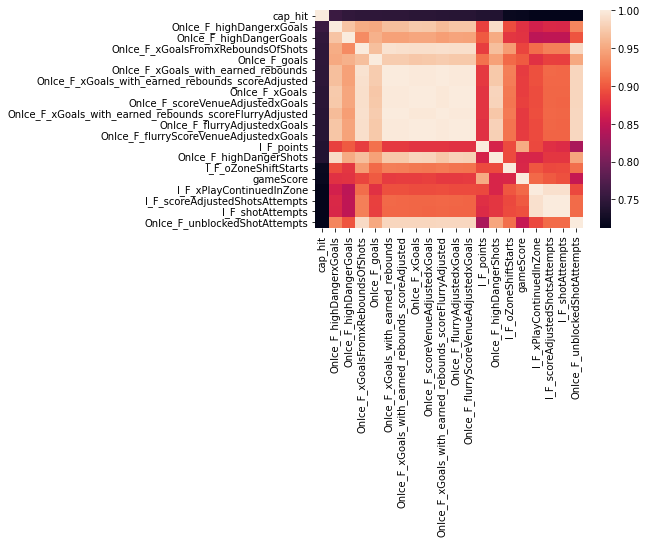

In [38]:
sns.heatmap(corr_matrix20x20)

In [39]:
## we discover a high multicollinearity between attributes
## consider dropping attributes or preprocessing further with pca and minmaxscaler

In [40]:
## for linear regression the data has to be divided to x and y so that x is the data and y is the label

In [41]:
## making sure there are no missing values on the dataset
dataset_wo_dummies_cap_hit.dropna(inplace=True)

In [42]:
# Splitting into train/test
X_train, X_test, y_train, y_test = train_test_split(dataset_wo_dummies_cap_hit.drop("cap_hit",axis=1), 
                                                    dataset_wo_dummies_cap_hit["cap_hit"],
                                                    test_size=.2, random_state=42)

In [43]:
len(X_train)==len(y_train), len(X_test)==len(y_test)

(True, True)

In [44]:
## building a linear regression model
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train) ## R^2 (coefficient of determination)

0.7568297187881594

In [45]:
## calculating root mean squared error (RMSE) for the model
actual_values = y_test
predictions = reg.predict(X_test)

difference = np.subtract(actual_values, predictions)
squared_error = np.square(difference)
MSE = squared_error.mean()
RMSE = math.sqrt(MSE)

In [46]:
## Trying the same thing with scaled and scaled pca data
## saving R^2 and RMSE for each model (including the previous one)
performance_dict = {'regular': (reg.score(X_train, y_train).round(5),RMSE)}

In [47]:
performance_dict 

{'regular': (0.75683, 1736804.3823622053)}

In [48]:
## standarizing the data
new_scaler = MinMaxScaler()
new_scaler.fit(dataset_wo_dummies_cap_hit.drop("cap_hit",axis=1))

scaled_X_train = new_scaler.transform(X_train)
scaled_X_test = new_scaler.transform(X_test)

In [49]:
## building a new linear regression model
scaled_reg = LinearRegression().fit(scaled_X_train, y_train)
scaled_reg.score(scaled_X_train, y_train) ## R^2 (coefficient of determination)

## calculating root mean squared error (RMSE) for the model
actual_values = y_test
predictions = scaled_reg.predict(scaled_X_test)

difference = np.subtract(actual_values, predictions)
squared_error = np.square(difference)
MSE = squared_error.mean()
RMSE = math.sqrt(MSE)

performance_dict['scaled']=(scaled_reg.score(scaled_X_train, y_train).round(5),RMSE)

In [50]:
performance_dict

{'regular': (0.75683, 1736804.3823622053),
 'scaled': (0.75683, 1736804.3823610754)}

In [51]:
## testing pca n_components for lowest RMSE
rmse_list = []
for n in np.arange(1,100):
    new_pca = PCA(n_components=n)
    new_pca.fit(scaled_X_train)
    pca_scaled_X_train = new_pca.transform(scaled_X_train)
    pca_scaled_X_test = new_pca.transform(scaled_X_test)
    
    ## building a new linear regression model
    pca_scaled_reg = LinearRegression().fit(pca_scaled_X_train, y_train)
    pca_scaled_reg.score(pca_scaled_X_train, y_train) ## R^2 (coefficient of determination)

    ## calculating root mean squared error (RMSE) for the model
    actual_values = y_test
    predictions = pca_scaled_reg.predict(pca_scaled_X_test)

    difference = np.subtract(actual_values, predictions)
    squared_error = np.square(difference)
    MSE = squared_error.mean()
    RMSE = math.sqrt(MSE)
    
    rmse_list.append(RMSE)

In [52]:
# Finding the highest performing n value
lowest_rmse_index = np.argmin(rmse_list)
best_n = np.arange(2,100)[lowest_rmse_index]
print("Best performing n_components value:",best_n)

Best performing n_components value: 31


In [53]:
## using pca on scaled data
final_pca = PCA(n_components=best_n)

final_pca.fit(scaled_X_train)
pca_scaled_X_train = final_pca.transform(scaled_X_train)
pca_scaled_X_test = final_pca.transform(scaled_X_test)

In [54]:
## building a new linear regression model
pca_scaled_reg = LinearRegression().fit(pca_scaled_X_train, y_train)
pca_scaled_reg.score(pca_scaled_X_train, y_train) ## R^2 (coefficient of determination)

## calculating root mean squared error (RMSE) for the model
actual_values = y_test
predictions = pca_scaled_reg.predict(pca_scaled_X_test)

difference = np.subtract(actual_values, predictions)
squared_error = np.square(difference)
MSE = squared_error.mean()
RMSE = math.sqrt(MSE)

performance_dict['pca_scaled']=(pca_scaled_reg.score(pca_scaled_X_train, y_train).round(5),RMSE)

In [55]:
performance_dict

{'regular': (0.75683, 1736804.3823622053),
 'scaled': (0.75683, 1736804.3823610754),
 'pca_scaled': (0.664, 1522136.8350795007)}

In [56]:
linear_results = pd.DataFrame(data=performance_dict, index=['R-squared', 'RMSE'])
linear_results

,regular,scaled,pca_scaled
R-squared,7.568300e-01,7.568300e-01,6.640000e-01
RMSE,1.736804e+06,1.736804e+06,1.522137e+06


In [57]:
## are we happy with the results? do we still want to explore options and methods to increase performance of our models
## remove irrelevant attributes? bring in new attributes? try dummies (mixed data supposedly not good for k-means clustering)

In [58]:
## correlations between dummies and cap_hit
dataset.corrwith(data['cap_hit'])[0:12]

C               -0.039968
D               -0.020875
L                0.044010
R                0.036407
draft_round_1    0.297596
draft_round_2   -0.098057
draft_round_3   -0.017265
draft_round_4   -0.074370
draft_round_5   -0.060793
draft_round_6    0.029145
draft_round_7   -0.067036
undrafted       -0.187878
dtype: float64

In [59]:
### TIME FOR K-MEANS CLUSTERING

In [60]:
## dividing data to labels and dataset
labels = dataset_wo_dummies['salary_cat']
data_wo_dummies = dataset_wo_dummies.drop(['salary_cat'], axis=1)

In [61]:
## NEXT STEP: NORMALIZATION?
## PCA?
## K-MEANS CLUSTERING
len(labels)==len(data_wo_dummies)

True

In [62]:
## running k-means without normalization or pca

#st = time.time()
num_clusters=4
k_means = KMeans(n_clusters=num_clusters, random_state=42).fit(data_wo_dummies)
#end = time.time()
#print(end-st)

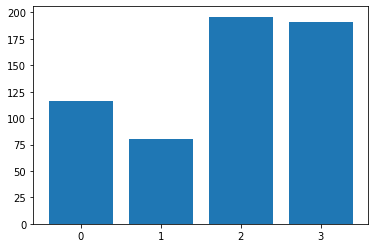

<Figure size 720x720 with 0 Axes>

In [63]:
#4 #Building a dictionary of clusters
clusters_dictionary = {
 0: 0,
 1: 0,
 2: 0,
 3: 0,
}

bars = list(np.arange(0,4))

for label in list(k_means.labels_):
    clusters_dictionary[label] += 1

values = clusters_dictionary.values()
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, values)

# Create names on the x-axis
plt.xticks(y_pos, bars)

plt.figure(figsize=(10,10))
plt.show()

In [64]:
## looks decent so far...
## let's find out if the clusters are any accurate though...

## try silhouette score
## save silhouette score for each model (including the previous one)

k_means_performance_dict = {'regular': silhouette_score(data_wo_dummies, k_means.predict(data_wo_dummies)),}

## Now trying the same thing with scaled and scaled pca data

In [65]:
## adding column cluster_num to the original data
data['cluster_num']=list(k_means.labels_)

In [66]:
## finding the 10 closest distances to cluster each cluster center
cluster_centers = k_means.cluster_centers_
for i in range(0,4):
    
    ## get indices of every record in cluster i
    cluster_idx_list = data[data['cluster_num']==i].index.to_list()
    
    ## create a new df for cluster i
    new_df = pd.DataFrame(data[data['cluster_num']==i]['salary_cat'], cluster_idx_list)
   
    cluster_center = cluster_centers[i]
    
    dist_list = []
    for idx in cluster_idx_list:
        row_array = data_wo_dummies.loc[idx].to_numpy()
        dist = distance.euclidean(row_array, cluster_center)
        dist_list.append(dist)
    
    new_df["distance"]=dist_list
    
    major_label = new_df.nsmallest(n=10, columns=["distance"])['salary_cat'].value_counts().index[0]

    ## Taking care of ties
    if (len(new_df.nsmallest(n=10, columns=["distance"])['salary_cat'].value_counts())>1 and 
        (major_label==new_df.nsmallest(n=10, columns=["distance"])['salary_cat'].value_counts().index[1])):
        ## Expand the list until no tie
        print("tie")
        for num in range(11,20):
            value_counts = new_df.nsmallest(n=num, columns=["distance"])['salary_cat'].value_counts()
            if value_counts.index[0]!=value_counts.index[1]:
                no_tie=True
                major_label = value_counts.index[0]
                break
    
    print("cluster",i,"majority label:",contracts_dict[major_label])


cluster 0 majority label: Entry Level
cluster 1 majority label: Entry Level
cluster 2 majority label: Squad Player
cluster 3 majority label: Squad Player


(array([0, 1, 2, 3]),
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

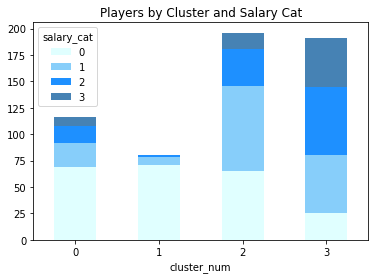

In [67]:
## not too good! where are the star players??


results = data.groupby(['cluster_num', 'salary_cat'])['playerId'].count().unstack().fillna(0)
results.plot(kind='bar', stacked=True, color=color_codes)
plt.title('Players by Cluster and Salary Cat')
plt.xticks(rotation=0, ha='center')

In [68]:
## NEXT TRY NORMALIZING THE DATA
## standarize the data
scaler = MinMaxScaler()
scaler.fit(data_wo_dummies)
scaled_data_wo_dummies = scaler.transform(data_wo_dummies)

In [69]:
## creating a new k means
num_clusters=4
k_means2 = KMeans(n_clusters=num_clusters, random_state=42).fit(scaled_data_wo_dummies)

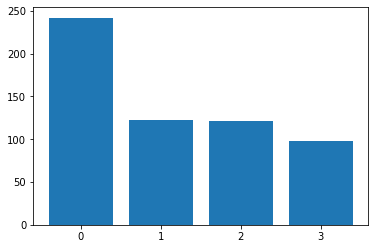

<Figure size 720x720 with 0 Axes>

In [70]:
#Build dictionary of clusters
clusters_dictionary = {
 0: 0,
 1: 0,
 2: 0,
 3: 0,
}

bars = list(np.arange(0,4))

for label in list(k_means2.labels_):
    clusters_dictionary[label] += 1

values = clusters_dictionary.values()
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, values)

# Create names on the x-axis
plt.xticks(y_pos, bars)

plt.figure(figsize=(10,10))
plt.show()
## Like the size of proportions so far...

In [71]:
k_means_performance_dict['scaled']=silhouette_score(scaled_data_wo_dummies, k_means2.predict(scaled_data_wo_dummies))
k_means_performance_dict ## first one was better

{'regular': 0.4192846408235464, 'scaled': 0.3245133565480106}

In [72]:
## adding column cluster_num to the original data
data['cluster_num']=list(k_means2.labels_)

In [73]:
## finding the 10 closest distances to cluster each cluster center
cluster_centers = k_means2.cluster_centers_

for i in range(0,4):
    
    ## get indices of every record in cluster i
    cluster_idx_list = data[data['cluster_num']==i].index.to_list()
    
    ## create a new df for cluster i
    new_df = pd.DataFrame(data[data['cluster_num']==i]['salary_cat'], cluster_idx_list)
   
    cluster_center = cluster_centers[i]
    
    
    dist_list = []
    for idx in cluster_idx_list:
        row_array = scaled_data_wo_dummies[idx]
        dist = distance.euclidean(row_array, cluster_center)
        dist_list.append(dist)
    
    new_df["distance"]=dist_list
    
    major_label = new_df.nsmallest(n=10, columns=["distance"])['salary_cat'].value_counts().index[0]
    ## Taking care of ties
    if (len(new_df.nsmallest(n=10, columns=["distance"])['salary_cat'].value_counts())>1 and 
        (major_label==new_df.nsmallest(n=10, columns=["distance"])['salary_cat'].value_counts().index[1])):
        ## Expand the list until no tie
        print("tie")
        for num in range(11,20):
            value_counts = new_df.nsmallest(n=num, columns=["distance"])['salary_cat'].value_counts()
            if value_counts.index[0]!=value_counts.index[1]:
                no_tie=True
                major_label = value_counts.index[0]
                break
    
                
    print("cluster",i,"majority label:",contracts_dict[major_label])

cluster 0 majority label: Entry Level
cluster 1 majority label: Entry Level
cluster 2 majority label: Star Player
cluster 3 majority label: Star Player


(array([0, 1, 2, 3]),
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

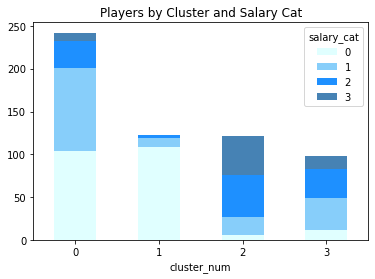

In [74]:
## proportions of each cluster
results = data.groupby(['cluster_num', 'salary_cat'])['playerId'].count().unstack().fillna(0)
results.plot(kind='bar', stacked=True, color=color_codes)
plt.title('Players by Cluster and Salary Cat')
plt.xticks(rotation=0, ha='center')

In [76]:
## NEXT trying PCA on scaled data
pca = PCA(n_components=30)
pca.fit(scaled_data_wo_dummies)

pca_scaled_data_wo_dummies = pca.transform(scaled_data_wo_dummies)

In [77]:
## creating a new k means
num_clusters=4
k_means3 = KMeans(n_clusters=num_clusters, random_state=42).fit(pca_scaled_data_wo_dummies)

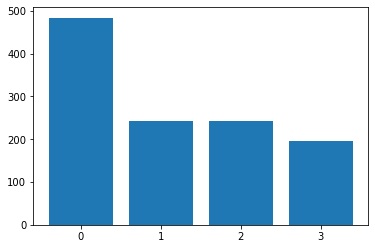

<Figure size 720x720 with 0 Axes>

In [78]:
bars = list(np.arange(0,4))

for label in list(k_means3.labels_):
    clusters_dictionary[label] += 1

values = clusters_dictionary.values()
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, values)

# Create names on the x-axis
plt.xticks(y_pos, bars)

plt.figure(figsize=(10,10))
plt.show()

In [79]:
k_means_performance_dict['pca_scaled']=silhouette_score(pca_scaled_data_wo_dummies, k_means3.predict(pca_scaled_data_wo_dummies))
k_means_performance_dict ## first one was the best

{'regular': 0.4192846408235464,
 'scaled': 0.3245133565480106,
 'pca_scaled': 0.33269061226955515}

In [80]:
silhouette_scores_k4 = pd.DataFrame(data=k_means_performance_dict, index=['silhouette_score'])

In [81]:
silhouette_scores_k4

,regular,scaled,pca_scaled
silhouette_score,0.419285,0.324513,0.332691


In [82]:
## adding column cluster_num to the original data
data['cluster_num']=list(k_means3.labels_)

In [83]:
## finding the 10 closest distances to cluster each cluster center
cluster_centers = k_means3.cluster_centers_

for i in range(0,4):
    
    ## get indices of every record in cluster i
    cluster_idx_list = data[data['cluster_num']==i].index.to_list()
    
    ## create a new df for cluster i
    new_df = pd.DataFrame(data[data['cluster_num']==i]['salary_cat'], cluster_idx_list)
   
    cluster_center = cluster_centers[i]
    
    
    
    dist_list = []
    for idx in cluster_idx_list:
        row_array = pca_scaled_data_wo_dummies[idx]#.loc[idx].to_numpy()

        dist = distance.euclidean(row_array, cluster_center)
        dist_list.append(dist)
    
    new_df["distance"]=dist_list
    
    major_label = new_df.nsmallest(n=10, columns=["distance"])['salary_cat'].value_counts().index[0]
    ## Taking care of ties
    if (len(new_df.nsmallest(n=10, columns=["distance"])['salary_cat'].value_counts())>1 and 
        (major_label==new_df.nsmallest(n=10, columns=["distance"])['salary_cat'].value_counts().index[1])):
        ## Expand the list until no tie
        print("tie")
        for num in range(11,20):
            value_counts = new_df.nsmallest(n=num, columns=["distance"])['salary_cat'].value_counts()
            if value_counts.index[0]!=value_counts.index[1]:
                no_tie=True
                major_label = value_counts.index[0]
                break
    
                
    print("cluster",i,"majority label:",contracts_dict[major_label])

cluster 0 majority label: Entry Level
cluster 1 majority label: Star Player
cluster 2 majority label: Entry Level
cluster 3 majority label: Star Player


(array([0, 1, 2, 3]),
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

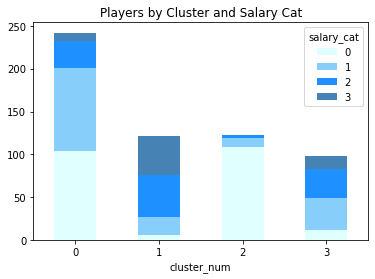

In [84]:
results = data.groupby(['cluster_num', 'salary_cat'])['playerId'].count().unstack().fillna(0)
results.plot(kind='bar', stacked=True, color=color_codes)
plt.title('Players by Cluster and Salary Cat')
plt.xticks(rotation=0, ha='center')

In [85]:
## as we saw earlier, the silhoutte score got worse when using scaled and scaled and pca scaled data
## overall with 4 clusters, the model offers some difference between clusters which is good.

In [86]:
### Next step: exploring different methods to measure clustering quality. (dissimilarity/similarity metrics)
## trying to find the optimal number of clusters (elbow method)
## trying to find the optimal preprocessing technique
## analyzing the clusters

In [87]:
## STANDARDIZE STYLE FOR EVERY GRAPH AFTER
#plt.style.use('seaborn-white')

In [88]:
distortions = []
distortions_scaled = []
distortions_pca_scaled = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(data_wo_dummies)
    distortions.append(kmeanModel.inertia_)
    kmeanModel.fit(scaled_data_wo_dummies)
    distortions_scaled.append(kmeanModel.inertia_)
    kmeanModel.fit(pca_scaled_data_wo_dummies)
    distortions_pca_scaled.append(kmeanModel.inertia_)

C:\Users\rsmid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\rsmid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\rsmid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [89]:
import matplotlib.gridspec as gridspec

Text(0.5, 1.0, 'pca scaled data')

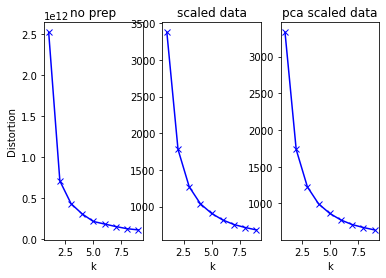

In [91]:
## The Elbow Method showing the optimal k

gs = gridspec.GridSpec(nrows=1, ncols=3)

plt.figure()

plt.subplot(gs[0,0])
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
#plt.title('The Elbow Method showing the optimal k: no prep')
plt.title('no prep')

plt.subplot(gs[0,1])
plt.plot(K, distortions_scaled, 'bx-')
plt.xlabel('k')
plt.ylabel(None)
plt.title('scaled data')

plt.subplot(gs[0,2])
plt.plot(K, distortions_pca_scaled, 'bx-')
plt.xlabel('k')
plt.ylabel(None)
plt.title('pca scaled data')

In [92]:
## should we try 3 clusters instead?

In [93]:
## trying which prep method will get the highest silhoutte score when k=3
silhouette_dict = {'regular':0, 'scaled':0, 'pca_scaled':0}
for key in silhouette_dict.keys():
    if key == 'regular':
        kmeanModel = KMeans(n_clusters=3, random_state=42)
        kmeanModel.fit(data_wo_dummies)
        silhouette_dict[key]=silhouette_score(data_wo_dummies, kmeanModel.predict(data_wo_dummies))
    elif key == 'scaled':
        kmeanModel = KMeans(n_clusters=3, random_state=42)
        kmeanModel.fit(scaled_data_wo_dummies)
        silhouette_dict[key]=silhouette_score(scaled_data_wo_dummies, kmeanModel.predict(scaled_data_wo_dummies))
    else:
        kmeanModel = KMeans(n_clusters=3, random_state=42)
        kmeanModel.fit(pca_scaled_data_wo_dummies)
        silhouette_dict[key]=silhouette_score(pca_scaled_data_wo_dummies, kmeanModel.predict(pca_scaled_data_wo_dummies))

In [94]:
silhouette_dict

{'regular': 0.5137690015486023,
 'scaled': 0.3233182740453659,
 'pca_scaled': 0.33037756190214584}

In [95]:
silhouette_scores_k3 = pd.DataFrame(data=silhouette_dict, index=['silhouette_score'])
silhouette_scores_k3

,regular,scaled,pca_scaled
silhouette_score,0.513769,0.323318,0.330378


In [96]:
## we see that data without prep provides the best result again
## however, is the difference that significant that we want to risk a potential bias that some attribute that has a wider range
## but is less significant will make the model biased

## considering to use pca_scaled data which had the second best silhoutte score (and lowest RMSE on the linear model)

In [97]:
## create a final k means model with 3 clusters and use pca_scaled_data_wo_dummies
num_clusters=3
k_means_final = KMeans(n_clusters=num_clusters, random_state=42).fit(pca_scaled_data_wo_dummies)

In [98]:
clusters_dictionary = {
    0: 0,
    1: 0,
    2: 0
}

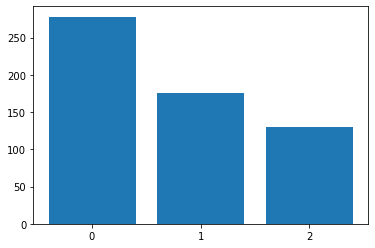

<Figure size 720x720 with 0 Axes>

In [99]:
bars = list(np.arange(0,3))

for label in list(k_means_final.labels_):
    clusters_dictionary[label] += 1

values = clusters_dictionary.values()
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, values)

# Create names on the x-axis
plt.xticks(y_pos, bars)

plt.figure(figsize=(10,10))
plt.show()

In [100]:
## adding column cluster_num to the original data
data['cluster_num']=list(k_means_final.labels_)

In [101]:
data['salary_cat']=[contracts_dict[cat] for cat in list(data['salary_cat'])]

In [102]:
## set colors for each salary_cat
colors = ['steelblue', 'dodgerblue', 'lightskyblue', 'lightcyan']
color_codes =[]
for clr in colors[::-1]:
    color_codes.append(mcolors.CSS4_COLORS[clr])

(array([0, 1, 2]), [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2')])

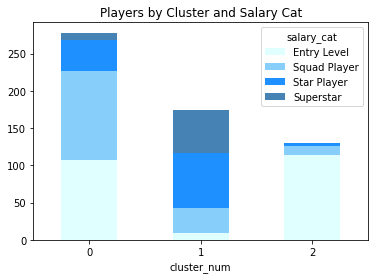

In [103]:
results = data.groupby(['cluster_num', 'salary_cat'])['playerId'].count().unstack().fillna(0)
results.plot(kind='bar', stacked=True, color=color_codes)
plt.title('Players by Cluster and Salary Cat')
plt.xticks(rotation=0, ha='center')

In [104]:
## looks good!! majority of the starplayers and superstars are in cluster 1
## however, the entry level players are divided into two of the clusters...
## let's see the top 10 closest labels of each cluster

In [105]:
## finding the 10 closest distances to cluster each cluster center
cluster_centers = k_means_final.cluster_centers_

for i in range(0,3):
    
    ## get indices of every record in cluster i
    cluster_idx_list = data[data['cluster_num']==i].index.to_list()
    
    ## create a new df for cluster i
    new_df = pd.DataFrame(data[data['cluster_num']==i]['salary_cat'], cluster_idx_list)
   
    cluster_center = cluster_centers[i]
    
    dist_list = []
    for idx in cluster_idx_list:
        row_array = pca_scaled_data_wo_dummies[idx]
        dist = distance.euclidean(row_array, cluster_center)
        dist_list.append(dist)
        
    new_df["distance"]=dist_list
    
    major_label = new_df.nsmallest(n=10, columns=["distance"])['salary_cat'].value_counts().index[0]
    ## Taking care of ties
    if (len(new_df.nsmallest(n=10, columns=["distance"])['salary_cat'].value_counts())>1 and 
        (major_label==new_df.nsmallest(n=10, columns=["distance"])['salary_cat'].value_counts().index[1])):
        ## Expand the list until no tie
        print("tie")
        for num in range(11,20):
            value_counts = new_df.nsmallest(n=num, columns=["distance"])['salary_cat'].value_counts()
            if value_counts.index[0]!=value_counts.index[1]:
                no_tie=True
                major_label = value_counts.index[0]
                break
    
                
    print("cluster",i,"top 10 closest:",major_label)

cluster 0 top 10 closest: Squad Player
cluster 1 top 10 closest: Star Player
cluster 2 top 10 closest: Entry Level


In [106]:
### NEXT EXPLORING AND ANALYZEING THE DATA ON CLUSTERS
## descriptive statistics, trends, etc.

In [107]:
cap_hits_in_millions = [(list(data['cap_hit'])[i])/1000000 for i in range(len(list(data['cap_hit'])))]

In [108]:
data['cap_hit_in_millions']=cap_hits_in_millions

In [109]:
## list of key attributes we want to interpret in order to analyze each cluster
key_attributes = ['cap_hit_in_millions','games_played', 'icetime', 'shifts']
key_attributes.extend(list(corr_matrix20x20.index)[1::])

In [110]:
#data[data['cluster_num']==2][key_attributes].describe()

,cap_hit_in_millions,games_played,icetime,shifts,OnIce_F_highDangerxGoals,OnIce_F_highDangerGoals,OnIce_F_xGoalsFromxReboundsOfShots,OnIce_F_goals,OnIce_F_xGoals_with_earned_rebounds,OnIce_F_xGoals_with_earned_rebounds_scoreAdjusted,...,OnIce_F_flurryAdjustedxGoals,OnIce_F_flurryScoreVenueAdjustedxGoals,I_F_points,OnIce_F_highDangerShots,I_F_oZoneShiftStarts,gameScore,I_F_xPlayContinuedInZone,I_F_scoreAdjustedShotsAttempts,I_F_shotAttempts,OnIce_F_unblockedShotAttempts
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,...,130.000000,130.000000,130.00000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,1.130375,24.130769,18311.046154,418.030769,3.641769,3.061538,2.058000,11.676923,12.265615,12.315615,...,12.141308,12.201769,5.70000,11.784615,43.461538,5.521615,15.710231,51.794231,51.584615,198.361538
std,0.921704,16.706954,12870.878890,290.305638,3.147968,3.127160,1.483047,9.487826,8.985288,9.017077,...,8.822317,8.865997,5.22316,9.696147,33.643630,5.952162,11.813701,38.000824,37.827389,139.614253
min,0.750000,1.000000,296.000000,9.000000,0.000000,0.000000,0.020000,0.000000,0.090000,0.080000,...,0.180000,0.180000,0.00000,0.000000,0.000000,-3.550000,0.000000,0.000000,0.000000,2.000000
25%,0.758750,8.250000,6219.500000,139.000000,1.127500,1.000000,0.795000,3.000000,4.375000,4.342500,...,4.437500,4.425000,2.00000,4.000000,16.000000,0.965000,5.022500,17.175000,17.000000,78.250000
50%,0.810833,23.000000,16961.500000,393.000000,3.010000,2.000000,1.965000,11.000000,11.680000,11.855000,...,11.085000,11.145000,4.50000,9.500000,38.500000,3.800000,13.860000,48.935000,49.000000,186.000000
75%,0.925000,40.000000,29787.500000,679.750000,5.720000,4.000000,3.245000,16.000000,19.502500,19.417500,...,19.335000,19.632500,8.00000,18.000000,66.000000,8.600000,22.767500,76.402500,77.000000,325.000000
max,5.700000,59.000000,44814.000000,989.000000,15.640000,14.000000,5.440000,40.000000,34.720000,34.830000,...,32.310000,32.630000,23.00000,43.000000,136.000000,27.020000,49.800000,148.680000,147.000000,484.000000


In [111]:
#data[data['cluster_num']==2]['draft_round'].value_counts()

1            43
undrafted    31
2            19
3            12
4            11
5             7
6             5
7             2
Name: draft_round, dtype: int64

In [110]:
#data[data['cluster_num']==1]['position'].value_counts()

In [111]:
#data[data['cluster_num']==1][['salary_cat', 'position']].value_counts()

In [112]:
## compare some of the means
## use the means of real values since the cluster centroids for our final model are pca values

cluster_0_means = list(data[data['cluster_num']==0][key_attributes].mean())
cluster_1_means = list(data[data['cluster_num']==1][key_attributes].mean())
cluster_2_means = list(data[data['cluster_num']==2][key_attributes].mean())

cluster_means = pd.DataFrame(
    {'cluster_0': cluster_0_means,
    'cluster_1': cluster_1_means,
    'cluster_2': cluster_2_means},
    index=key_attributes)

In [113]:
cluster_means

,cluster_0,cluster_1,cluster_2
cap_hit_in_millions,2.667268,5.957828,1.130375
games_played,68.093525,76.480000,24.130769
icetime,64868.492806,91144.274286,18311.046154
shifts,1413.521583,1820.582857,418.030769
OnIce_F_highDangerxGoals,15.907698,35.208629,3.641769
OnIce_F_highDangerGoals,14.751799,35.120000,3.061538
OnIce_F_xGoalsFromxReboundsOfShots,7.756799,14.414000,2.058000
OnIce_F_goals,48.773381,99.057143,11.676923
OnIce_F_xGoals_with_earned_rebounds,48.316079,90.688057,12.265615
OnIce_F_xGoals_with_earned_rebounds_scoreAdjusted,48.490612,90.976286,12.315615


In [114]:
## let's have a look at the superstars and star players that are part of clusters 0 and 2

In [115]:
data[(data['cluster_num']==0)&((data['salary_cat']=='Star Player')|(data['salary_cat']=='Superstar'))][key_attributes]

,cap_hit_in_millions,games_played,icetime,shifts,OnIce_F_highDangerxGoals,OnIce_F_highDangerGoals,OnIce_F_xGoalsFromxReboundsOfShots,OnIce_F_goals,OnIce_F_xGoals_with_earned_rebounds,OnIce_F_xGoals_with_earned_rebounds_scoreAdjusted,...,OnIce_F_flurryAdjustedxGoals,OnIce_F_flurryScoreVenueAdjustedxGoals,I_F_points,OnIce_F_highDangerShots,I_F_oZoneShiftStarts,gameScore,I_F_xPlayContinuedInZone,I_F_scoreAdjustedShotsAttempts,I_F_shotAttempts,OnIce_F_unblockedShotAttempts
9,6.500000,56,50462,1137,16.64,17,8.13,45,45.87,45.35,...,45.24,44.87,24,50,170,31.06,75.59,244.26,250,674
33,5.000000,63,66479,1493,21.68,15,9.52,55,55.71,55.49,...,51.95,51.62,34,68,251,29.46,58.96,206.48,208,767
37,6.375000,65,54831,1256,15.51,15,9.64,42,50.79,51.45,...,46.71,47.34,23,44,242,27.82,61.79,201.25,197,826
39,5.900000,67,73493,1528,24.97,21,11.91,63,71.16,71.23,...,68.47,68.63,35,66,233,51.05,76.38,238.40,237,1060
111,5.500000,37,40974,837,7.71,8,6.65,37,35.92,35.69,...,31.85,31.59,23,25,145,24.82,58.11,166.23,168,557
121,5.000000,74,74990,1600,19.70,21,9.07,65,54.77,55.31,...,52.52,53.04,44,56,225,24.73,44.81,158.28,156,778
122,6.150000,56,71014,1470,20.52,22,8.54,62,51.36,52.50,...,51.67,52.73,21,57,142,24.25,66.65,227.48,226,786
140,7.575000,65,82485,1531,32.68,34,13.65,103,84.81,85.34,...,81.28,81.92,40,84,272,52.60,68.45,234.90,234,1114
141,6.000000,74,74489,1619,19.10,19,8.90,59,49.05,48.98,...,50.45,50.47,45,53,230,38.44,96.79,302.08,304,788
162,4.750000,53,48524,1105,17.48,15,6.87,50,46.18,46.86,...,45.38,45.98,32,47,109,43.66,66.78,209.50,205,600


In [116]:
## we find out that many of these players have had broken seasons and thus haven't played near the full 82 games...
## however we see multiple players with games played in 70s

In [117]:
data[(data['cluster_num']==0)&((data['salary_cat']=='Star Player')|(data['salary_cat']=='Superstar'))
     &(data['games_played']>=70)][key_attributes]

,cap_hit_in_millions,games_played,icetime,shifts,OnIce_F_highDangerxGoals,OnIce_F_highDangerGoals,OnIce_F_xGoalsFromxReboundsOfShots,OnIce_F_goals,OnIce_F_xGoals_with_earned_rebounds,OnIce_F_xGoals_with_earned_rebounds_scoreAdjusted,...,OnIce_F_flurryAdjustedxGoals,OnIce_F_flurryScoreVenueAdjustedxGoals,I_F_points,OnIce_F_highDangerShots,I_F_oZoneShiftStarts,gameScore,I_F_xPlayContinuedInZone,I_F_scoreAdjustedShotsAttempts,I_F_shotAttempts,OnIce_F_unblockedShotAttempts
121,5.00,74,74990,1600,19.70,21,9.07,65,54.77,55.31,...,52.52,53.04,44,56,225,24.73,44.81,158.28,156,778
141,6.00,74,74489,1619,19.10,19,8.90,59,49.05,48.98,...,50.45,50.47,45,53,230,38.44,96.79,302.08,304,788
193,4.60,72,83518,1713,17.06,19,9.09,60,56.27,56.05,...,55.26,55.13,17,58,145,22.33,53.18,173.12,176,874
212,5.25,82,60302,1429,15.96,13,7.70,39,44.87,45.63,...,44.17,44.75,21,41,221,25.76,56.01,177.25,171,782
247,5.80,76,100526,2021,26.74,17,10.21,65,68.89,68.89,...,66.42,66.38,25,77,254,24.04,63.13,210.41,211,994
274,4.50,76,67635,1613,17.24,17,9.12,47,57.78,57.40,...,54.36,53.93,30,51,212,34.03,74.64,241.35,244,877
310,4.50,74,67022,1562,17.33,15,8.43,50,49.90,49.57,...,50.63,50.45,38,53,162,43.70,82.22,264.91,269,768
338,5.75,78,99595,2087,18.65,18,10.69,73,67.51,68.30,...,64.88,65.67,28,58,159,32.75,55.81,226.37,225,1058
340,7.00,75,68469,1598,8.17,3,6.32,28,36.19,36.23,...,35.69,35.92,14,28,125,2.92,42.04,144.48,145,645
394,10.50,71,74445,1649,20.18,18,10.17,61,60.34,60.42,...,56.64,56.81,37,54,259,33.02,62.81,188.06,188,876


In [118]:
## since many of the key attributes are metrics that value attacking play
## one of the reasons why some of these players are not valued higher in my model could be indicated from their position

In [119]:
data[(data['cluster_num']==0)&((data['salary_cat']=='Star Player')|(data['salary_cat']=='Superstar'))
     &(data['games_played']>=70)]['position'].value_counts()

D    5
L    4
C    3
R    2
Name: position, dtype: int64

In [120]:
## find that the majority of these players are attackers...
## defenders usually get more time on ice and thus they don't lack that much in other metrics than those that are derived
## from goalscoring

In [121]:
## the only superstar in cluster 0...
## is this player overvalued?
data.iloc[394]

playerId                      8473604
season                           2021
name                   Jonathan Toews
team                              CHI
position                            C
                            ...      
salary                      2900000.0
cap_hit                    10500000.0
salary_cat                  Superstar
cluster_num                         0
cap_hit_in_millions              10.5
Name: 394, Length: 152, dtype: object

In [122]:
test_data = dataset_wo_dummies_cap_hit.copy()
test_data.drop("cap_hit",axis=1, inplace=True)
## standarize the data
new_scaler = MinMaxScaler()
new_scaler.fit(test_data)
scaled_test_data = new_scaler.transform(test_data)
pca_scaled_test_data = final_pca.transform(scaled_test_data)
jtoews = pca_scaled_test_data[394]

print("predicted cap hit in millions:",(pca_scaled_reg.predict(jtoews.reshape(1, -1))[0]/1000000).round(3))

predicted cap hit in millions: 4.632


In [123]:
## there were only four players in cluster 2 who were star players (not a single superstar)
## these players missed over half of the season...
data[(data['cluster_num']==2)&(data['salary_cat']=="Star Player")][key_attributes]

,cap_hit_in_millions,games_played,icetime,shifts,OnIce_F_highDangerxGoals,OnIce_F_highDangerGoals,OnIce_F_xGoalsFromxReboundsOfShots,OnIce_F_goals,OnIce_F_xGoals_with_earned_rebounds,OnIce_F_xGoals_with_earned_rebounds_scoreAdjusted,...,OnIce_F_flurryAdjustedxGoals,OnIce_F_flurryScoreVenueAdjustedxGoals,I_F_points,OnIce_F_highDangerShots,I_F_oZoneShiftStarts,gameScore,I_F_xPlayContinuedInZone,I_F_scoreAdjustedShotsAttempts,I_F_shotAttempts,OnIce_F_unblockedShotAttempts
23,5.500,41,36458,739,8.82,6,5.44,32,29.91,30.39,...,30.84,31.41,17,26,111,21.23,49.80,148.68,146,471
27,5.700,37,33675,694,10.03,12,4.82,36,29.04,29.45,...,27.52,27.87,23,33,105,27.02,39.14,134.30,132,442
38,4.725,21,16747,369,4.72,4,2.03,10,11.08,10.97,...,10.99,10.88,6,15,49,5.74,19.62,61.14,62,179
564,5.250,26,30483,623,9.35,5,4.03,24,28.31,28.57,...,27.97,28.19,8,27,67,13.30,18.34,68.74,69,381


In [124]:
## note that the first two have significantly better scores in some of the categories than the bottom two
## does this mean that they we projected to have a better season without injury?

## many players who fall into cluster 2 does so because of the lack of games played
## since many of these players are "entry level" players, this fact suggests that they were not ready for the NHL level yet
## and thus didn't get that many games...

In [125]:
#data[(data['cluster_num']==1)&(data['salary_cat']=='Superstar')][key_attributes]

In [126]:
## cluster 1 by position

data[(data['cluster_num']==1)].groupby(['position']).mean()[key_attributes]

,cap_hit_in_millions,games_played,icetime,shifts,OnIce_F_highDangerxGoals,OnIce_F_highDangerGoals,OnIce_F_xGoalsFromxReboundsOfShots,OnIce_F_goals,OnIce_F_xGoals_with_earned_rebounds,OnIce_F_xGoals_with_earned_rebounds_scoreAdjusted,...,OnIce_F_flurryAdjustedxGoals,OnIce_F_flurryScoreVenueAdjustedxGoals,I_F_points,OnIce_F_highDangerShots,I_F_oZoneShiftStarts,gameScore,I_F_xPlayContinuedInZone,I_F_scoreAdjustedShotsAttempts,I_F_shotAttempts,OnIce_F_unblockedShotAttempts
position,,,,,,,,,,,,,,,,,,,,,
C,5.933315,76.403226,85335.580645,1738.096774,36.495968,36.596774,14.278226,98.580645,90.048387,90.347903,...,87.983548,88.308387,64.822581,95.032258,305.741935,67.768548,105.188871,331.422903,329.112903,1183.209677
D,5.803800,76.636364,106033.018182,2067.945455,35.209273,34.345455,14.735818,100.036364,94.231273,94.522000,...,92.291818,92.623636,44.490909,95.909091,270.345455,49.922000,95.674364,332.457091,332.218182,1309.836364
L,6.464134,77.727273,84668.575758,1693.545455,35.251818,36.727273,14.707273,103.484848,91.386061,91.782727,...,88.390303,88.814545,71.848485,92.636364,330.272727,75.310909,119.460000,381.813939,378.878788,1208.515152
R,5.689161,74.680000,81342.520000,1648.640000,31.957600,31.040000,13.655600,92.240000,83.558000,83.669600,...,80.746400,80.926000,62.240000,85.320000,325.400000,64.207600,117.272800,368.646800,368.440000,1139.440000


In [127]:
## cluster 1 by salary cat

data[(data['cluster_num']==1)].groupby(['salary_cat']).mean()[key_attributes]

,cap_hit_in_millions,games_played,icetime,shifts,OnIce_F_highDangerxGoals,OnIce_F_highDangerGoals,OnIce_F_xGoalsFromxReboundsOfShots,OnIce_F_goals,OnIce_F_xGoals_with_earned_rebounds,OnIce_F_xGoals_with_earned_rebounds_scoreAdjusted,...,OnIce_F_flurryAdjustedxGoals,OnIce_F_flurryScoreVenueAdjustedxGoals,I_F_points,OnIce_F_highDangerShots,I_F_oZoneShiftStarts,gameScore,I_F_xPlayContinuedInZone,I_F_scoreAdjustedShotsAttempts,I_F_shotAttempts,OnIce_F_unblockedShotAttempts
salary_cat,,,,,,,,,,,,,,,,,,,,,
Entry Level,1.007870,78.777778,88256.000000,1763.777778,28.202222,28.111111,13.294444,90.444444,82.126667,82.211111,...,79.033333,79.163333,54.000000,81.444444,288.777778,56.794444,102.755556,338.000000,338.888889,1136.444444
Squad Player,3.301471,76.588235,86993.352941,1793.529412,29.716765,28.970588,12.482353,83.941176,79.517647,79.819412,...,78.183529,78.508824,46.823529,82.941176,256.647059,52.109706,90.373235,300.256176,298.647059,1104.294118
Star Player,5.642818,76.712329,91387.013699,1843.438356,34.288767,33.616438,14.243151,96.054795,88.693014,88.972055,...,86.645068,86.968219,55.835616,91.301370,295.534247,60.119589,103.235616,335.276849,333.876712,1214.671233
Superstar,8.633448,75.779661,93676.576271,1816.559322,40.580339,41.593220,15.909322,112.796610,100.899661,101.222542,...,97.829492,98.186441,71.847458,104.050847,338.305085,74.003390,120.747627,388.533390,386.677966,1310.542373


In [128]:
## let's look at the "entry level" players who made cluster 1
data[(data['cluster_num']==1)&(data['salary_cat']=='Entry Level')][key_attributes]

,cap_hit_in_millions,games_played,icetime,shifts,OnIce_F_highDangerxGoals,OnIce_F_highDangerGoals,OnIce_F_xGoalsFromxReboundsOfShots,OnIce_F_goals,OnIce_F_xGoals_with_earned_rebounds,OnIce_F_xGoals_with_earned_rebounds_scoreAdjusted,...,OnIce_F_flurryAdjustedxGoals,OnIce_F_flurryScoreVenueAdjustedxGoals,I_F_points,OnIce_F_highDangerShots,I_F_oZoneShiftStarts,gameScore,I_F_xPlayContinuedInZone,I_F_scoreAdjustedShotsAttempts,I_F_shotAttempts,OnIce_F_unblockedShotAttempts
22,0.925000,75,80582,1580,22.83,21,12.08,77,70.08,70.01,...,68.18,68.14,61,61,348,58.22,104.81,331.45,333,1055
177,0.800000,75,93960,1930,28.37,31,13.28,83,82.17,81.82,...,76.57,76.29,35,75,282,44.68,96.72,346.52,348,1138
218,0.950000,79,73671,1560,24.57,24,12.92,101,80.34,81.21,...,78.34,79.20,63,82,252,78.83,92.73,301.23,296,1086
262,0.863333,82,113384,2112,39.14,38,16.43,112,103.41,103.44,...,98.50,98.52,50,110,260,46.12,103.43,349.22,355,1329
289,1.400000,78,83676,1739,27.05,27,13.14,99,83.20,83.12,...,77.26,77.28,68,71,358,66.89,143.85,451.60,457,1116
360,0.863333,81,96252,1813,31.85,29,14.37,89,89.71,90.16,...,90.49,91.00,43,94,216,62.52,115.64,401.28,400,1314
406,1.450000,75,82064,1687,27.15,30,11.53,89,71.60,71.88,...,71.09,71.42,67,76,286,64.63,102.13,329.90,327,1044
420,0.925000,82,89332,1687,31.51,32,14.99,87,85.57,85.67,...,83.23,83.34,57,102,339,50.88,88.78,286.43,287,1149
449,0.894167,82,81383,1766,21.35,21,10.91,77,73.06,72.59,...,67.64,67.28,42,62,258,38.38,76.71,244.37,247,997


In [129]:
## an assumption could be that these are up and coming players who have just made their breakthrough
## thus their salary-> cap_hit doesn't reflect yet their level (they haven't signed a new contract yet)

In [130]:
## let's see if this is true...

data[(data['cluster_num']==1)&(data['salary_cat']=='Entry Level')][['name', 'team', 'draft_year', 'draft_round', 'draft_number', 'cap_hit']]

,name,team,draft_year,draft_round,draft_number,cap_hit
22,Trevor Zegras,ANA,2019,1,9,925000.0
177,Mark Giordano,TOR,undrafted,undrafted,undrafted,800000.0
218,Michael Bunting,TOR,2014,4,117,950000.0
262,Moritz Seider,DET,2019,1,6,863333.0
289,Tage Thompson,BUF,2016,1,26,1400000.0
360,Evan Bouchard,EDM,2018,1,10,863333.0
406,Troy Terry,ANA,2015,5,148,1450000.0
420,Lucas Raymond,DET,2020,1,4,925000.0
449,Dawson Mercer,NJD,2020,1,18,894167.0


In [131]:
## we find that 4 of these players could be described as "recent" entrants to the league (drafted in or after 2019)
## Mark Giordano is one the leagues oldest veterans. 
## It seems he is still playing on a high level despite having a smaller contract.

In [132]:
list(data[(data['cluster_num']==1)&(data['salary_cat']=='Entry Level')].index)

[22, 177, 218, 262, 289, 360, 406, 420, 449]

In [133]:
## let's see what their contract values should be based on our linear model

test_data = dataset_wo_dummies_cap_hit.copy()
test_data.drop("cap_hit",axis=1, inplace=True)

## standarize the data
new_scaler = MinMaxScaler()
new_scaler.fit(test_data)
scaled_test_data = new_scaler.transform(test_data)
pca_scaled_test_data = final_pca.transform(scaled_test_data)


print("Predicted cap hits")
print()
test_players_idx_lst = list(data[(data['cluster_num']==1)&(data['salary_cat']=='Entry Level')].index)
for idx in test_players_idx_lst:
    player = pca_scaled_test_data[idx]
    print(data.iloc[idx]['name'],(pca_scaled_reg.predict(player.reshape(1, -1))[0]/1000000).round(3))

Predicted cap hits

Trevor Zegras 4.964
Mark Giordano 4.843
Michael Bunting 3.737
Moritz Seider 5.63
Tage Thompson 5.848
Evan Bouchard 5.087
Troy Terry 4.208
Lucas Raymond 4.444
Dawson Mercer 3.65


In [134]:
## let's find out what kind of contracts the recent top draft picks have in general
recent_top_picks = data[((data['draft_year']==str(2019))|(data['draft_year']==str(2020))|(data['draft_year']==str(2021)))
    &(data['draft_round']==str(1))]
recent_top_picks[['salary_cat']].value_counts()

salary_cat  
Entry Level     23
Squad Player     2
Superstar        1
dtype: int64

In [135]:
## the most recent superstar
recent_top_picks[recent_top_picks['salary_cat']=='Superstar']

,playerId,season,name,team,position,games_played,icetime,shifts,gameScore,onIce_xGoalsPercentage,...,OffIce_F_shotAttempts,OffIce_A_shotAttempts,draft_round,draft_number,draft_year,salary,cap_hit,salary_cat,cluster_num,cap_hit_in_millions
191,8481559,2021,Jack Hughes,NJD,C,49,57522,1089,56.23,0.57,...,1733,1917,1,1,2019,7000000.0,8000000.0,Superstar,0,8.0


In [136]:
recent_top_picks[recent_top_picks['salary_cat']=='Squad Player']

,playerId,season,name,team,position,games_played,icetime,shifts,gameScore,onIce_xGoalsPercentage,...,OffIce_F_shotAttempts,OffIce_A_shotAttempts,draft_round,draft_number,draft_year,salary,cap_hit,salary_cat,cluster_num,cap_hit_in_millions
367,8481554,2021,Kaapo Kakko,NYR,R,43,39850,828,18.25,0.55,...,1585,1960,1,2,2019,1800000.0,2100000.0,Squad Player,2,2.1000
505,8481523,2021,Kirby Dach,CHI,C,70,75786,1526,15.83,0.48,...,2546,3022,1,3,2019,2500000.0,3362500.0,Squad Player,0,3.3625


In [137]:
## both of these players were drafted in 2019 and thus have just played their real entry level contract and signed a new deal
## both of them are categorized as squad players

## fun fact: the three players represented from 2019 draft class 
## who have signed new more valuable contracts were picks 1, 2, and 3 from that year. 

In [138]:
## let's see what their contract values should be based on our linear model

test_data = dataset_wo_dummies_cap_hit.copy()
test_data.drop("cap_hit",axis=1, inplace=True)

## standarize the data
new_scaler = MinMaxScaler()
new_scaler.fit(test_data)
scaled_test_data = new_scaler.transform(test_data)
pca_scaled_test_data = final_pca.transform(scaled_test_data)

jhughes = pca_scaled_test_data[191]
kkakko = pca_scaled_test_data[367]
kdach = pca_scaled_test_data[505]

test_players = [jhughes, kkakko, kdach]
for player in test_players:
    print("predicted cap hit in millions:",(pca_scaled_reg.predict(player.reshape(1, -1))[0]/1000000).round(3))

predicted cap hit in millions: 5.498
predicted cap hit in millions: 2.276
predicted cap hit in millions: 3.622


<AxesSubplot:ylabel='draft_round'>

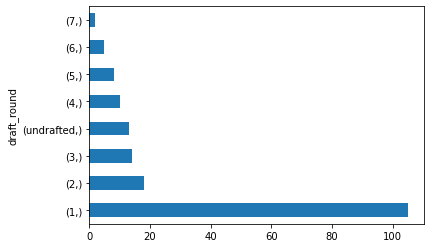

In [139]:
## cluster 1 players are mostly former 1 round picks
data[data['cluster_num']==1][['draft_round']].value_counts().plot(kind='barh')


<AxesSubplot:ylabel='draft_year'>

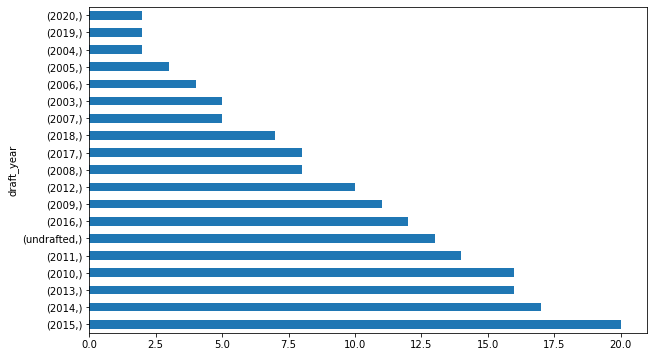

In [140]:
## they have been in the league for 7+ years
data[data['cluster_num']==1][['draft_year']].value_counts().plot(kind='barh',figsize=(10,6))

<AxesSubplot:ylabel='team'>

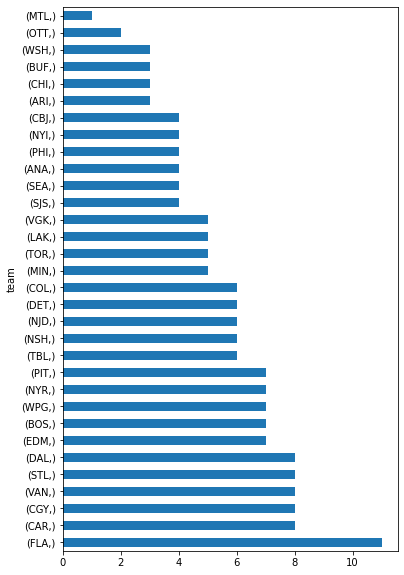

In [141]:
## and they play for...
data[data['cluster_num']==1][['team']].value_counts().plot(kind='barh',figsize=(6,10))

<AxesSubplot:ylabel='salary_cat'>

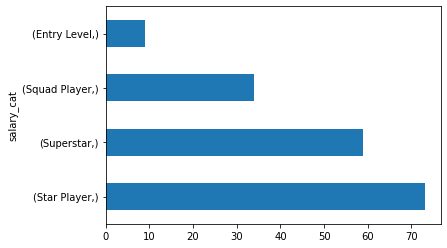

In [142]:
data[data['cluster_num']==1][['salary_cat']].value_counts().plot(kind='barh')

<AxesSubplot:xlabel='team'>

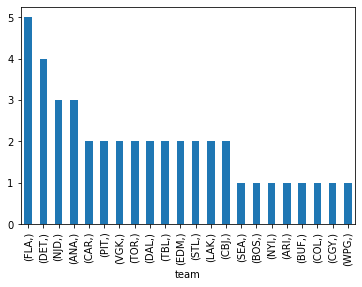

In [143]:
## teams that best exploit the cheaper players
data[(data['cluster_num']==1)&((data['salary_cat']=="Squad Player")|(data['salary_cat']=="Entry Level"))][['team']].value_counts().plot(kind='bar')

In [144]:
## finding that FLA, DET, NJD, and ANA differ from the rest of the teams
## at least DET, NJD, and ANA are known to rebuild and they have some of the top picks from last couple years